In [20]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dsets 
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

#hyperparameters
batchsize=1 #batch-size of 1
imgsize=720 #image of size (128,128)

#creating transformations so that the image is ready to be fed to the neural network
transform=transforms.Compose([transforms.Resize(imgsize),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]) # Applying transformation(resizing,tensor conversion and normalization) to the image  

#loading the dataset
dataset=dsets.ImageFolder(root='mydata',transform=transform)
dataloader=torch.utils.data.DataLoader(dataset,batch_size=batchsize,shuffle=True,num_workers=4) #Dataloader helps is to load data in specific batch size and whether we want to shuffle it or not and num_workers=-1 means it uses all the parallel processes available

print('Dataloader executed')
#GANs use a different type of weight initialization called Xavier's Initialization
def weights(network):
	classname=network.__class__.__name__ # this line searches for the name of the class in the network defination
	if classname.find('Conv') !=-1: #this line finds the occurance of the string 'Conv' in the network function's defination and if the string 'Conv' is present then it activates the if loop
		with torch.no_grad():
			network.weight.normal_(0.0,0.02)
	elif classname.find('BatchNorm')!=-1: #similar operation as above
		with torch.no_grad():
			network.weight.data.normal_(1.0,0.02)
		# network.bias.data.fill_(0)
# Defining the generator network

class generator(nn.Module):
	def __init__(self):
		super(generator,self).__init__() # this line passes all the goodness of nn.module in the generator class that we defined
#(1,1)  ------------------> size of output image    
		self.main=nn.Sequential(nn.ConvTranspose2d(100,1024,4,1,0,bias=False), #100 is the input noise vector, 512 are the new feature maps,4 is the size of kernel(4,4),1 is the stride of the kernel,0 is the padding and bias is set to false
			nn.ReLU(True), #to introduce non-linearity
			nn.BatchNorm2d(1024), #normalizing all the new feature maps
# (4,4)  ------------------> size of output image
			nn.ConvTranspose2d(1024,512,4,2,1,bias=False),
			nn.ReLU(True),
			nn.BatchNorm2d(512),
# (8,8)  ------------------> size of output image
			nn.ConvTranspose2d(512,256,4,2,1,bias=False),
			nn.ReLU(True),
			nn.BatchNorm2d(256),
#(16,16)  ------------------> size of output image
			nn.ConvTranspose2d(256,128,4,2,1,bias=False),
			nn.ReLU(True),
			nn.BatchNorm2d(128),
#(32,32)  ------------------> size of output image
			nn.ConvTranspose2d(128,64,4,2,1,bias=False),
			nn.ReLU(True),
			nn.BatchNorm2d(64),
#(64,64)  ------------------> size of output image
			nn.ConvTranspose2d(64,32,4,2,1,bias=False),
			nn.ReLU(True),
			nn.BatchNorm2d(32),
# (128,128)  ------------------> size of output image
			nn.ConvTranspose2d(32,16,3,3,12,bias=False),
			nn.ReLU(True),
			nn.BatchNorm2d(16),
#(360,360)  ------------------> size of output image
			nn.ConvTranspose2d(16,3,4,2,1,bias=False),
#(720,720)  ------------------> size of output image
			nn.Tanh() #Tanh is selected here because the dataset has values between -1 and 1 , also Tanh is bounded, this bounded and symmetrical nature of the function helps the model to learn faster 
			)
	def forward(self,x):
		output=self.main(x)
		return output
netG=generator()
netG.cuda()
netG.apply(weights) #applying weights initizlization function on the generator function


class discriminator(nn.Module):
	def __init__(self):
		super(discriminator,self).__init__() #to activate inheritance
		self.main=nn.Sequential(
			nn.Conv2d(3,64,4,2,1,bias=False),
			nn.LeakyReLU(0.02,inplace=True),
			nn.Conv2d(64,128,4,2,1,bias=False),
			nn.BatchNorm2d(128),
			nn.LeakyReLU(0.02,inplace=True),
			nn.Conv2d(128,256,4,2,1,bias=False),
			nn.BatchNorm2d(256),
			nn.LeakyReLU(0.02,inplace=True),
			nn.Conv2d(256,512,4,2,1,bias=False),
			nn.BatchNorm2d(512),
			nn.LeakyReLU(0.02,inplace=True),
			nn.Conv2d(512,1024,4,2,1,bias=False),
			nn.BatchNorm2d(1024),
			nn.LeakyReLU(0.02,inplace=True),
			nn.Conv2d(1024,1,4,1,0,bias=False),
			nn.Sigmoid()
			)
	def forward(self,x):
		output=self.main(x)
		return output.view(-1) # .view(-1) is used to reshape the convouled image and flatten it along a single axis.

print('Networks defined')
netD=discriminator()
netD.cuda()
netD.apply(weights) #applying weights initizlization function on the generator function

run=500 ### number of epochs



###### TRAINING THE GANs ########
criterion = nn.BCELoss()
optimizerD=optim.Adam(netD.parameters(),lr=0.001,betas=(0.5,0.999)) #the value of betas is selected from experimentation
optimizerG=optim.Adam(netG.parameters(),lr=0.001,betas=(0.5,0.999))
err_dis=[]
err_gen=[]


print('Loop starting now')


for epoch in range(run):	
	for i,data in enumerate(dataloader,0): #0 in the enumerate parenthesis is just the starting value we want 'i' to take.
		netD.zero_grad() #clearing gradient buffers and setting it to zero for every new batch



		###Training the discriminator network on real images

		images,_=data #_ here holds the labels of the images. As we dont want the labels here we just throw it away
		real=Variable(images.cuda()) #to compute gradients, we need to wrap the image with a Variable class
		output=netD(real) #computing the outputs through discriminator which will be a number between 0 and 1 giving probablity of image being real or fake
		real_targets=Variable(torch.ones(output.size()[0]).cuda()) 
		error_real=criterion(output,real_targets) #calculating the error for real images and their output given by our discriminator network

		###Training the network on fake images
		noise=Variable(torch.randn(real.size()[0],100,1,1).cuda()) #this line can be interpreted like a matrix which has real.size()[0] number of rows and 100 number of columns(technically feature maps) and each column has a 1x1 array
		fake_output=netG(noise)  #generator uses this noise vector to generate a mini-batch of fakeimages
		output=netD(fake_output.detach()) #the fake_output is a torch variable and it contains the data as well as the gradients, but we dont want this gradients so we will only use the data and for that we use .detach() method
		fake_target=Variable(torch.zeros(output.size()[0]).cuda())#instantiating the fake target as 0s
		error_fake=criterion(output,fake_target) #calculating the error of fake images with wrt their output

		error_total=error_real+error_fake
		error_total.backward() #this line back-propagates the error 
		optimizerD.step()      #this line updates the parameters of netD

		##Training the generator
		netG.zero_grad() #initializing the gradients of generaotr neural net
		output=netD(fake_output) #notice here we didnt use .detach() because we want to update the weights of generator unlike previously where we were updating the weights of discriminator, because the fake_output is generated by generator and not discriminator
		target=Variable(torch.ones(output.size()[0]).cuda()) #here we defined targets as 1s because we want the generator to generate near perfect images which the discriminator should predict as real( or target =1) 
		error_gen=criterion(output,target)
		error_gen.backward()
		optimizerG.step()
		print('[%d/%d][%d/%d] Loss_D: %.4f----Loss_G: %.4f' % (epoch, run, i, len(dataloader), error_total.data, error_gen.data))
		if i%1000==0:
			vutils.save_image(real, '%s/real_samples.png' % "./results", normalize = True)
			fake = netG(noise)
			vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d.png' % ("./results", epoch), normalize = True)
	err_dis.append(torch.sum(error_total))
	err_gen.append(torch.sum(error_gen))

print('Training Completed')

Dataloader executed
Networks defined
Loop starting now
[0/500][0/500] Loss_D: 1.9790----Loss_G: 8.6978
[0/500][1/500] Loss_D: 4.1130----Loss_G: 1.8985
[0/500][2/500] Loss_D: 11.6648----Loss_G: 7.7622
[0/500][3/500] Loss_D: 4.4717----Loss_G: 2.4916
[0/500][4/500] Loss_D: 1.7835----Loss_G: 4.4390
[0/500][5/500] Loss_D: 2.0192----Loss_G: 0.7521
[0/500][6/500] Loss_D: 3.0116----Loss_G: 5.1461
[0/500][7/500] Loss_D: 2.5202----Loss_G: 1.5297
[0/500][8/500] Loss_D: 1.2822----Loss_G: 2.0811
[0/500][9/500] Loss_D: 0.7211----Loss_G: 2.2003
[0/500][10/500] Loss_D: 0.5234----Loss_G: 2.4087
[0/500][11/500] Loss_D: 0.4250----Loss_G: 3.0569
[0/500][12/500] Loss_D: 0.3218----Loss_G: 3.3396
[0/500][13/500] Loss_D: 0.2688----Loss_G: 3.2705
[0/500][14/500] Loss_D: 0.2625----Loss_G: 3.8022
[0/500][15/500] Loss_D: 0.4216----Loss_G: 4.3594
[0/500][16/500] Loss_D: 0.3381----Loss_G: 3.6820
[0/500][17/500] Loss_D: 0.3787----Loss_G: 3.0084
[0/500][18/500] Loss_D: 0.3923----Loss_G: 5.1565
[0/500][19/500] Loss_D:

[0/500][164/500] Loss_D: 1.1810----Loss_G: 1.4252
[0/500][165/500] Loss_D: 0.8846----Loss_G: 4.8308
[0/500][166/500] Loss_D: 2.0795----Loss_G: 0.7532
[0/500][167/500] Loss_D: 2.1962----Loss_G: 4.7975
[0/500][168/500] Loss_D: 2.2192----Loss_G: 1.2130
[0/500][169/500] Loss_D: 0.9178----Loss_G: 2.6466
[0/500][170/500] Loss_D: 0.7506----Loss_G: 2.6575
[0/500][171/500] Loss_D: 0.4350----Loss_G: 3.6487
[0/500][172/500] Loss_D: 0.2552----Loss_G: 3.5244
[0/500][173/500] Loss_D: 0.2485----Loss_G: 2.7469
[0/500][174/500] Loss_D: 0.9275----Loss_G: 8.1721
[0/500][175/500] Loss_D: 5.9048----Loss_G: 1.1855
[0/500][176/500] Loss_D: 1.4410----Loss_G: 1.8861
[0/500][177/500] Loss_D: 0.9248----Loss_G: 2.6347
[0/500][178/500] Loss_D: 0.7822----Loss_G: 1.7960
[0/500][179/500] Loss_D: 0.7364----Loss_G: 3.4725
[0/500][180/500] Loss_D: 0.5138----Loss_G: 1.7383
[0/500][181/500] Loss_D: 1.0850----Loss_G: 5.9047
[0/500][182/500] Loss_D: 3.4024----Loss_G: 1.3544
[0/500][183/500] Loss_D: 2.8946----Loss_G: 3.9296


[0/500][327/500] Loss_D: 1.2862----Loss_G: 0.9509
[0/500][328/500] Loss_D: 1.4728----Loss_G: 1.9407
[0/500][329/500] Loss_D: 1.2108----Loss_G: 1.5231
[0/500][330/500] Loss_D: 1.4866----Loss_G: 0.4301
[0/500][331/500] Loss_D: 1.8139----Loss_G: 3.9533
[0/500][332/500] Loss_D: 2.5719----Loss_G: 0.4798
[0/500][333/500] Loss_D: 2.1900----Loss_G: 3.2542
[0/500][334/500] Loss_D: 2.3789----Loss_G: 0.2650
[0/500][335/500] Loss_D: 1.6580----Loss_G: 2.1714
[0/500][336/500] Loss_D: 1.0970----Loss_G: 1.0554
[0/500][337/500] Loss_D: 0.7710----Loss_G: 1.5942
[0/500][338/500] Loss_D: 0.9211----Loss_G: 1.9555
[0/500][339/500] Loss_D: 1.0942----Loss_G: 0.6257
[0/500][340/500] Loss_D: 0.9847----Loss_G: 3.6357
[0/500][341/500] Loss_D: 1.6207----Loss_G: 0.4382
[0/500][342/500] Loss_D: 1.4089----Loss_G: 2.4292
[0/500][343/500] Loss_D: 0.4622----Loss_G: 2.8262
[0/500][344/500] Loss_D: 0.4238----Loss_G: 2.2214
[0/500][345/500] Loss_D: 0.5260----Loss_G: 3.1180
[0/500][346/500] Loss_D: 0.7957----Loss_G: 0.7027


[0/500][490/500] Loss_D: 0.5516----Loss_G: 2.4170
[0/500][491/500] Loss_D: 0.0991----Loss_G: 4.3360
[0/500][492/500] Loss_D: 0.4844----Loss_G: 5.3868
[0/500][493/500] Loss_D: 0.6405----Loss_G: 2.7745
[0/500][494/500] Loss_D: 0.7785----Loss_G: 5.1026
[0/500][495/500] Loss_D: 0.4388----Loss_G: 2.8165
[0/500][496/500] Loss_D: 0.3260----Loss_G: 3.3650
[0/500][497/500] Loss_D: 0.1387----Loss_G: 4.9471
[0/500][498/500] Loss_D: 0.0475----Loss_G: 6.2743
[0/500][499/500] Loss_D: 0.1509----Loss_G: 4.4969
[1/500][0/500] Loss_D: 0.1250----Loss_G: 4.9719
[1/500][1/500] Loss_D: 0.0614----Loss_G: 6.0509
[1/500][2/500] Loss_D: 0.0399----Loss_G: 5.0893
[1/500][3/500] Loss_D: 0.0329----Loss_G: 5.8232
[1/500][4/500] Loss_D: 0.0373----Loss_G: 5.2180
[1/500][5/500] Loss_D: 0.1014----Loss_G: 4.6868
[1/500][6/500] Loss_D: 0.0969----Loss_G: 5.4629
[1/500][7/500] Loss_D: 0.0393----Loss_G: 5.5602
[1/500][8/500] Loss_D: 0.0894----Loss_G: 5.4236
[1/500][9/500] Loss_D: 0.0493----Loss_G: 6.5391
[1/500][10/500] Loss

[1/500][156/500] Loss_D: 0.6900----Loss_G: 3.4995
[1/500][157/500] Loss_D: 0.5920----Loss_G: 3.2375
[1/500][158/500] Loss_D: 0.3737----Loss_G: 3.6268
[1/500][159/500] Loss_D: 0.3061----Loss_G: 2.6379
[1/500][160/500] Loss_D: 0.1432----Loss_G: 4.1954
[1/500][161/500] Loss_D: 0.1675----Loss_G: 4.2670
[1/500][162/500] Loss_D: 0.1684----Loss_G: 3.5340
[1/500][163/500] Loss_D: 0.0857----Loss_G: 4.5333
[1/500][164/500] Loss_D: 0.1816----Loss_G: 4.4831
[1/500][165/500] Loss_D: 0.1212----Loss_G: 4.7067
[1/500][166/500] Loss_D: 0.1556----Loss_G: 4.4144
[1/500][167/500] Loss_D: 0.0610----Loss_G: 5.4513
[1/500][168/500] Loss_D: 0.3799----Loss_G: 1.7629
[1/500][169/500] Loss_D: 2.3388----Loss_G: 4.6832
[1/500][170/500] Loss_D: 1.4036----Loss_G: 3.0940
[1/500][171/500] Loss_D: 0.2549----Loss_G: 3.0508
[1/500][172/500] Loss_D: 0.9365----Loss_G: 5.5325
[1/500][173/500] Loss_D: 2.5629----Loss_G: 0.6720
[1/500][174/500] Loss_D: 2.0283----Loss_G: 3.5724
[1/500][175/500] Loss_D: 0.9755----Loss_G: 1.3831


[1/500][319/500] Loss_D: 0.5344----Loss_G: 4.3683
[1/500][320/500] Loss_D: 0.2352----Loss_G: 7.5949
[1/500][321/500] Loss_D: 0.1228----Loss_G: 4.4656
[1/500][322/500] Loss_D: 0.7130----Loss_G: 5.4278
[1/500][323/500] Loss_D: 0.9318----Loss_G: 4.3564
[1/500][324/500] Loss_D: 0.6988----Loss_G: 4.2982
[1/500][325/500] Loss_D: 0.3151----Loss_G: 4.1036
[1/500][326/500] Loss_D: 0.1791----Loss_G: 3.3575
[1/500][327/500] Loss_D: 0.0893----Loss_G: 5.0141
[1/500][328/500] Loss_D: 0.2043----Loss_G: 3.9205
[1/500][329/500] Loss_D: 0.1519----Loss_G: 4.2099
[1/500][330/500] Loss_D: 0.0501----Loss_G: 5.3052
[1/500][331/500] Loss_D: 0.0880----Loss_G: 3.9269
[1/500][332/500] Loss_D: 0.0354----Loss_G: 5.1641
[1/500][333/500] Loss_D: 0.0358----Loss_G: 5.1110
[1/500][334/500] Loss_D: 0.0544----Loss_G: 4.2642
[1/500][335/500] Loss_D: 0.0351----Loss_G: 5.2064
[1/500][336/500] Loss_D: 0.0285----Loss_G: 5.1754
[1/500][337/500] Loss_D: 0.4054----Loss_G: 5.7876
[1/500][338/500] Loss_D: 0.9970----Loss_G: 3.0573


[1/500][482/500] Loss_D: 0.9730----Loss_G: 1.3587
[1/500][483/500] Loss_D: 1.1601----Loss_G: 4.7831
[1/500][484/500] Loss_D: 1.0418----Loss_G: 1.6366
[1/500][485/500] Loss_D: 1.3875----Loss_G: 5.6491
[1/500][486/500] Loss_D: 2.2178----Loss_G: 0.9404
[1/500][487/500] Loss_D: 0.5613----Loss_G: 2.4180
[1/500][488/500] Loss_D: 0.4401----Loss_G: 4.5325
[1/500][489/500] Loss_D: 0.4805----Loss_G: 4.2667
[1/500][490/500] Loss_D: 0.3310----Loss_G: 3.0157
[1/500][491/500] Loss_D: 0.2315----Loss_G: 2.8430
[1/500][492/500] Loss_D: 0.0810----Loss_G: 3.7123
[1/500][493/500] Loss_D: 0.1608----Loss_G: 3.6759
[1/500][494/500] Loss_D: 0.0850----Loss_G: 4.3333
[1/500][495/500] Loss_D: 0.1066----Loss_G: 3.4534
[1/500][496/500] Loss_D: 0.1057----Loss_G: 4.4950
[1/500][497/500] Loss_D: 0.0980----Loss_G: 3.9089
[1/500][498/500] Loss_D: 0.0775----Loss_G: 3.7681
[1/500][499/500] Loss_D: 0.0720----Loss_G: 3.7643
[2/500][0/500] Loss_D: 0.0331----Loss_G: 6.1516
[2/500][1/500] Loss_D: 0.0324----Loss_G: 5.1285
[2/5

[2/500][148/500] Loss_D: 1.5887----Loss_G: 2.5025
[2/500][149/500] Loss_D: 2.5810----Loss_G: 6.1961
[2/500][150/500] Loss_D: 2.8217----Loss_G: 1.4214
[2/500][151/500] Loss_D: 0.3909----Loss_G: 1.8548
[2/500][152/500] Loss_D: 2.4085----Loss_G: 7.0052
[2/500][153/500] Loss_D: 4.4681----Loss_G: 1.4878
[2/500][154/500] Loss_D: 0.6352----Loss_G: 1.5255
[2/500][155/500] Loss_D: 1.4052----Loss_G: 6.1192
[2/500][156/500] Loss_D: 4.1320----Loss_G: 0.6607
[2/500][157/500] Loss_D: 3.5598----Loss_G: 2.9627
[2/500][158/500] Loss_D: 4.7950----Loss_G: 0.7228
[2/500][159/500] Loss_D: 1.9036----Loss_G: 1.8752
[2/500][160/500] Loss_D: 1.0524----Loss_G: 1.5823
[2/500][161/500] Loss_D: 1.4914----Loss_G: 3.2321
[2/500][162/500] Loss_D: 2.0766----Loss_G: 0.1388
[2/500][163/500] Loss_D: 2.0079----Loss_G: 2.9275
[2/500][164/500] Loss_D: 1.5567----Loss_G: 0.9376
[2/500][165/500] Loss_D: 0.7861----Loss_G: 2.4838
[2/500][166/500] Loss_D: 0.7264----Loss_G: 2.7519
[2/500][167/500] Loss_D: 1.2258----Loss_G: 0.2854


[2/500][311/500] Loss_D: 0.3463----Loss_G: 4.3042
[2/500][312/500] Loss_D: 0.1505----Loss_G: 4.0045
[2/500][313/500] Loss_D: 0.1414----Loss_G: 5.1144
[2/500][314/500] Loss_D: 0.0988----Loss_G: 3.7279
[2/500][315/500] Loss_D: 0.1364----Loss_G: 3.3278
[2/500][316/500] Loss_D: 0.1019----Loss_G: 3.7110
[2/500][317/500] Loss_D: 0.0913----Loss_G: 4.1274
[2/500][318/500] Loss_D: 0.0853----Loss_G: 3.8167
[2/500][319/500] Loss_D: 0.1169----Loss_G: 3.3033
[2/500][320/500] Loss_D: 0.1201----Loss_G: 3.5515
[2/500][321/500] Loss_D: 0.1048----Loss_G: 4.0385
[2/500][322/500] Loss_D: 0.0622----Loss_G: 4.2958
[2/500][323/500] Loss_D: 0.1248----Loss_G: 3.5831
[2/500][324/500] Loss_D: 0.2462----Loss_G: 4.1493
[2/500][325/500] Loss_D: 0.3279----Loss_G: 4.2595
[2/500][326/500] Loss_D: 0.0803----Loss_G: 3.2231
[2/500][327/500] Loss_D: 0.4826----Loss_G: 5.5116
[2/500][328/500] Loss_D: 0.5268----Loss_G: 4.1062
[2/500][329/500] Loss_D: 0.1611----Loss_G: 2.8831
[2/500][330/500] Loss_D: 0.1144----Loss_G: 3.7908


[2/500][474/500] Loss_D: 0.1704----Loss_G: 4.0296
[2/500][475/500] Loss_D: 0.0728----Loss_G: 4.5466
[2/500][476/500] Loss_D: 0.0361----Loss_G: 5.7468
[2/500][477/500] Loss_D: 0.0511----Loss_G: 4.0364
[2/500][478/500] Loss_D: 0.1619----Loss_G: 5.2667
[2/500][479/500] Loss_D: 0.1732----Loss_G: 3.0254
[2/500][480/500] Loss_D: 0.0496----Loss_G: 5.1316
[2/500][481/500] Loss_D: 0.1077----Loss_G: 3.6745
[2/500][482/500] Loss_D: 0.0287----Loss_G: 6.2689
[2/500][483/500] Loss_D: 0.0310----Loss_G: 4.8921
[2/500][484/500] Loss_D: 0.0275----Loss_G: 4.8925
[2/500][485/500] Loss_D: 0.0192----Loss_G: 6.7463
[2/500][486/500] Loss_D: 0.0211----Loss_G: 5.0725
[2/500][487/500] Loss_D: 0.0129----Loss_G: 6.2920
[2/500][488/500] Loss_D: 0.0939----Loss_G: 4.5803
[2/500][489/500] Loss_D: 0.0357----Loss_G: 4.9121
[2/500][490/500] Loss_D: 0.1424----Loss_G: 4.3745
[2/500][491/500] Loss_D: 0.1247----Loss_G: 4.0342
[2/500][492/500] Loss_D: 0.0698----Loss_G: 4.0991
[2/500][493/500] Loss_D: 0.0600----Loss_G: 4.0349


[3/500][140/500] Loss_D: 2.6313----Loss_G: 0.7256
[3/500][141/500] Loss_D: 0.7150----Loss_G: 1.5330
[3/500][142/500] Loss_D: 0.3568----Loss_G: 2.5767
[3/500][143/500] Loss_D: 0.3832----Loss_G: 3.0032
[3/500][144/500] Loss_D: 0.3182----Loss_G: 3.3316
[3/500][145/500] Loss_D: 1.7770----Loss_G: 5.5521
[3/500][146/500] Loss_D: 5.0209----Loss_G: 0.3227
[3/500][147/500] Loss_D: 1.2620----Loss_G: 1.1675
[3/500][148/500] Loss_D: 0.6177----Loss_G: 1.9555
[3/500][149/500] Loss_D: 0.4551----Loss_G: 2.5129
[3/500][150/500] Loss_D: 0.4679----Loss_G: 2.1620
[3/500][151/500] Loss_D: 2.3964----Loss_G: 4.3333
[3/500][152/500] Loss_D: 4.0907----Loss_G: 2.6852
[3/500][153/500] Loss_D: 0.6356----Loss_G: 0.3816
[3/500][154/500] Loss_D: 4.0592----Loss_G: 1.9885
[3/500][155/500] Loss_D: 1.7869----Loss_G: 1.1926
[3/500][156/500] Loss_D: 1.7591----Loss_G: 1.0878
[3/500][157/500] Loss_D: 1.1272----Loss_G: 0.7261
[3/500][158/500] Loss_D: 1.6976----Loss_G: 2.6441
[3/500][159/500] Loss_D: 1.9051----Loss_G: 0.5696


[3/500][303/500] Loss_D: 1.5822----Loss_G: 5.2042
[3/500][304/500] Loss_D: 3.4078----Loss_G: 2.4298
[3/500][305/500] Loss_D: 1.0662----Loss_G: 0.2900
[3/500][306/500] Loss_D: 0.8394----Loss_G: 2.6297
[3/500][307/500] Loss_D: 1.9267----Loss_G: 7.7207
[3/500][308/500] Loss_D: 6.7505----Loss_G: 0.7450
[3/500][309/500] Loss_D: 1.5125----Loss_G: 1.1259
[3/500][310/500] Loss_D: 0.8559----Loss_G: 1.7082
[3/500][311/500] Loss_D: 0.3369----Loss_G: 2.3426
[3/500][312/500] Loss_D: 0.7683----Loss_G: 4.0192
[3/500][313/500] Loss_D: 1.1533----Loss_G: 2.2838
[3/500][314/500] Loss_D: 1.6366----Loss_G: 1.5876
[3/500][315/500] Loss_D: 0.2689----Loss_G: 2.1687
[3/500][316/500] Loss_D: 0.1339----Loss_G: 2.7547
[3/500][317/500] Loss_D: 4.5332----Loss_G: 4.8536
[3/500][318/500] Loss_D: 4.1326----Loss_G: 1.9827
[3/500][319/500] Loss_D: 0.6229----Loss_G: 1.0402
[3/500][320/500] Loss_D: 3.2784----Loss_G: 1.8171
[3/500][321/500] Loss_D: 0.8215----Loss_G: 2.8856
[3/500][322/500] Loss_D: 1.3977----Loss_G: 1.3502


[3/500][466/500] Loss_D: 0.6526----Loss_G: 1.4479
[3/500][467/500] Loss_D: 1.3717----Loss_G: 4.1386
[3/500][468/500] Loss_D: 3.7524----Loss_G: 1.6481
[3/500][469/500] Loss_D: 1.2610----Loss_G: 0.6196
[3/500][470/500] Loss_D: 1.3147----Loss_G: 1.9869
[3/500][471/500] Loss_D: 1.6133----Loss_G: 0.2684
[3/500][472/500] Loss_D: 1.7788----Loss_G: 2.1022
[3/500][473/500] Loss_D: 1.8676----Loss_G: 0.3544
[3/500][474/500] Loss_D: 1.5384----Loss_G: 1.5080
[3/500][475/500] Loss_D: 1.1766----Loss_G: 0.7019
[3/500][476/500] Loss_D: 1.1862----Loss_G: 1.3581
[3/500][477/500] Loss_D: 1.0792----Loss_G: 0.4649
[3/500][478/500] Loss_D: 2.1476----Loss_G: 2.8577
[3/500][479/500] Loss_D: 2.3281----Loss_G: 1.7494
[3/500][480/500] Loss_D: 1.0880----Loss_G: 0.9479
[3/500][481/500] Loss_D: 1.3948----Loss_G: 1.8860
[3/500][482/500] Loss_D: 1.6161----Loss_G: 0.4723
[3/500][483/500] Loss_D: 0.7153----Loss_G: 1.1040
[3/500][484/500] Loss_D: 1.4963----Loss_G: 2.9505
[3/500][485/500] Loss_D: 2.6744----Loss_G: 0.4100


[4/500][132/500] Loss_D: 1.2570----Loss_G: 1.2411
[4/500][133/500] Loss_D: 0.6095----Loss_G: 1.2872
[4/500][134/500] Loss_D: 1.1230----Loss_G: 1.9794
[4/500][135/500] Loss_D: 0.7666----Loss_G: 1.9899
[4/500][136/500] Loss_D: 0.4104----Loss_G: 1.7929
[4/500][137/500] Loss_D: 0.9867----Loss_G: 2.7590
[4/500][138/500] Loss_D: 0.7201----Loss_G: 2.1856
[4/500][139/500] Loss_D: 0.6762----Loss_G: 1.6957
[4/500][140/500] Loss_D: 0.3725----Loss_G: 3.2810
[4/500][141/500] Loss_D: 2.1878----Loss_G: 2.9498
[4/500][142/500] Loss_D: 2.0123----Loss_G: 2.5944
[4/500][143/500] Loss_D: 0.5428----Loss_G: 0.9505
[4/500][144/500] Loss_D: 0.9767----Loss_G: 1.8032
[4/500][145/500] Loss_D: 0.4898----Loss_G: 2.5321
[4/500][146/500] Loss_D: 0.4506----Loss_G: 2.4373
[4/500][147/500] Loss_D: 0.5808----Loss_G: 1.8937
[4/500][148/500] Loss_D: 0.8244----Loss_G: 1.5899
[4/500][149/500] Loss_D: 0.3423----Loss_G: 2.9168
[4/500][150/500] Loss_D: 0.7185----Loss_G: 2.3922
[4/500][151/500] Loss_D: 1.3754----Loss_G: 1.6022


[4/500][295/500] Loss_D: 1.1121----Loss_G: 3.5760
[4/500][296/500] Loss_D: 2.0010----Loss_G: 3.8695
[4/500][297/500] Loss_D: 1.2662----Loss_G: 1.5704
[4/500][298/500] Loss_D: 1.2932----Loss_G: 2.7542
[4/500][299/500] Loss_D: 1.2417----Loss_G: 0.7742
[4/500][300/500] Loss_D: 1.9498----Loss_G: 2.8774
[4/500][301/500] Loss_D: 2.0262----Loss_G: 0.4019
[4/500][302/500] Loss_D: 2.2868----Loss_G: 1.9458
[4/500][303/500] Loss_D: 1.9652----Loss_G: 1.2188
[4/500][304/500] Loss_D: 1.2888----Loss_G: 0.8033
[4/500][305/500] Loss_D: 1.7894----Loss_G: 0.7813
[4/500][306/500] Loss_D: 1.3851----Loss_G: 1.4292
[4/500][307/500] Loss_D: 1.0639----Loss_G: 1.5936
[4/500][308/500] Loss_D: 0.9673----Loss_G: 1.4029
[4/500][309/500] Loss_D: 1.2880----Loss_G: 0.8935
[4/500][310/500] Loss_D: 3.0955----Loss_G: 1.4367
[4/500][311/500] Loss_D: 2.1023----Loss_G: 1.0507
[4/500][312/500] Loss_D: 1.3871----Loss_G: 0.5448
[4/500][313/500] Loss_D: 1.6190----Loss_G: 1.2265
[4/500][314/500] Loss_D: 0.9079----Loss_G: 2.6103


[4/500][458/500] Loss_D: 0.5985----Loss_G: 1.5948
[4/500][459/500] Loss_D: 0.8770----Loss_G: 2.5536
[4/500][460/500] Loss_D: 1.7377----Loss_G: 0.7370
[4/500][461/500] Loss_D: 1.7455----Loss_G: 1.7272
[4/500][462/500] Loss_D: 1.0581----Loss_G: 1.5732
[4/500][463/500] Loss_D: 0.4557----Loss_G: 2.0884
[4/500][464/500] Loss_D: 1.1786----Loss_G: 2.1867
[4/500][465/500] Loss_D: 0.5018----Loss_G: 2.7737
[4/500][466/500] Loss_D: 0.7729----Loss_G: 1.6328
[4/500][467/500] Loss_D: 0.3953----Loss_G: 1.8344
[4/500][468/500] Loss_D: 0.2813----Loss_G: 2.4477
[4/500][469/500] Loss_D: 0.2909----Loss_G: 3.9829
[4/500][470/500] Loss_D: 2.4983----Loss_G: 3.3197
[4/500][471/500] Loss_D: 1.7317----Loss_G: 1.5455
[4/500][472/500] Loss_D: 0.2416----Loss_G: 3.6633
[4/500][473/500] Loss_D: 1.6247----Loss_G: 1.3391
[4/500][474/500] Loss_D: 1.5849----Loss_G: 1.8970
[4/500][475/500] Loss_D: 1.4999----Loss_G: 1.4374
[4/500][476/500] Loss_D: 1.5339----Loss_G: 0.7063
[4/500][477/500] Loss_D: 1.5752----Loss_G: 1.4735


[5/500][124/500] Loss_D: 0.0328----Loss_G: 4.8700
[5/500][125/500] Loss_D: 0.0358----Loss_G: 4.8447
[5/500][126/500] Loss_D: 0.0474----Loss_G: 4.6064
[5/500][127/500] Loss_D: 0.0197----Loss_G: 5.4796
[5/500][128/500] Loss_D: 0.0195----Loss_G: 5.6933
[5/500][129/500] Loss_D: 0.0583----Loss_G: 4.2933
[5/500][130/500] Loss_D: 0.0565----Loss_G: 3.9702
[5/500][131/500] Loss_D: 0.0291----Loss_G: 5.9519
[5/500][132/500] Loss_D: 0.0349----Loss_G: 4.8058
[5/500][133/500] Loss_D: 0.0235----Loss_G: 5.0508
[5/500][134/500] Loss_D: 0.0266----Loss_G: 5.4685
[5/500][135/500] Loss_D: 0.0391----Loss_G: 5.0485
[5/500][136/500] Loss_D: 0.0591----Loss_G: 4.4125
[5/500][137/500] Loss_D: 0.0918----Loss_G: 4.0235
[5/500][138/500] Loss_D: 0.0310----Loss_G: 5.8473
[5/500][139/500] Loss_D: 0.0554----Loss_G: 4.5934
[5/500][140/500] Loss_D: 0.0316----Loss_G: 5.2596
[5/500][141/500] Loss_D: 0.0386----Loss_G: 4.8199
[5/500][142/500] Loss_D: 0.0671----Loss_G: 4.1263
[5/500][143/500] Loss_D: 0.0597----Loss_G: 4.4683


[5/500][287/500] Loss_D: 0.1401----Loss_G: 6.1497
[5/500][288/500] Loss_D: 0.0624----Loss_G: 3.7854
[5/500][289/500] Loss_D: 0.1387----Loss_G: 3.6146
[5/500][290/500] Loss_D: 0.0820----Loss_G: 4.2518
[5/500][291/500] Loss_D: 0.0324----Loss_G: 7.1651
[5/500][292/500] Loss_D: 0.0281----Loss_G: 6.0944
[5/500][293/500] Loss_D: 0.0308----Loss_G: 6.5849
[5/500][294/500] Loss_D: 0.0615----Loss_G: 3.6073
[5/500][295/500] Loss_D: 0.0407----Loss_G: 4.2800
[5/500][296/500] Loss_D: 0.0131----Loss_G: 6.9352
[5/500][297/500] Loss_D: 0.0307----Loss_G: 6.0638
[5/500][298/500] Loss_D: 0.0129----Loss_G: 7.9089
[5/500][299/500] Loss_D: 0.0224----Loss_G: 5.6632
[5/500][300/500] Loss_D: 0.0118----Loss_G: 5.9418
[5/500][301/500] Loss_D: 0.0094----Loss_G: 5.8845
[5/500][302/500] Loss_D: 0.0118----Loss_G: 5.7375
[5/500][303/500] Loss_D: 0.0735----Loss_G: 3.8778
[5/500][304/500] Loss_D: 0.0140----Loss_G: 7.0053
[5/500][305/500] Loss_D: 0.0241----Loss_G: 4.8325
[5/500][306/500] Loss_D: 0.0163----Loss_G: 5.7230


[5/500][450/500] Loss_D: 0.3549----Loss_G: 3.3151
[5/500][451/500] Loss_D: 1.4006----Loss_G: 0.7424
[5/500][452/500] Loss_D: 1.1847----Loss_G: 2.4994
[5/500][453/500] Loss_D: 0.6424----Loss_G: 4.1344
[5/500][454/500] Loss_D: 0.8487----Loss_G: 3.6459
[5/500][455/500] Loss_D: 0.1009----Loss_G: 3.1556
[5/500][456/500] Loss_D: 1.4933----Loss_G: 4.5327
[5/500][457/500] Loss_D: 0.3771----Loss_G: 6.3449
[5/500][458/500] Loss_D: 0.4864----Loss_G: 2.4905
[5/500][459/500] Loss_D: 0.0533----Loss_G: 5.0830
[5/500][460/500] Loss_D: 0.0478----Loss_G: 3.6908
[5/500][461/500] Loss_D: 0.4607----Loss_G: 3.2050
[5/500][462/500] Loss_D: 0.0789----Loss_G: 4.8124
[5/500][463/500] Loss_D: 0.2222----Loss_G: 3.2566
[5/500][464/500] Loss_D: 0.0962----Loss_G: 5.4821
[5/500][465/500] Loss_D: 0.1021----Loss_G: 3.4338
[5/500][466/500] Loss_D: 0.0418----Loss_G: 4.1797
[5/500][467/500] Loss_D: 0.5071----Loss_G: 3.1787
[5/500][468/500] Loss_D: 0.1945----Loss_G: 4.1460
[5/500][469/500] Loss_D: 0.1108----Loss_G: 4.3369


[6/500][116/500] Loss_D: 0.0149----Loss_G: 6.0835
[6/500][117/500] Loss_D: 0.0243----Loss_G: 7.6337
[6/500][118/500] Loss_D: 0.0136----Loss_G: 6.5069
[6/500][119/500] Loss_D: 0.0163----Loss_G: 5.8772
[6/500][120/500] Loss_D: 0.0143----Loss_G: 6.9479
[6/500][121/500] Loss_D: 0.0085----Loss_G: 6.9230
[6/500][122/500] Loss_D: 0.0086----Loss_G: 6.5446
[6/500][123/500] Loss_D: 0.0098----Loss_G: 6.0572
[6/500][124/500] Loss_D: 0.0150----Loss_G: 5.4767
[6/500][125/500] Loss_D: 0.0110----Loss_G: 6.2655
[6/500][126/500] Loss_D: 0.0054----Loss_G: 7.2687
[6/500][127/500] Loss_D: 0.0107----Loss_G: 5.7674
[6/500][128/500] Loss_D: 0.0081----Loss_G: 7.0112
[6/500][129/500] Loss_D: 0.0130----Loss_G: 5.6495
[6/500][130/500] Loss_D: 0.0139----Loss_G: 5.2513
[6/500][131/500] Loss_D: 0.0113----Loss_G: 5.6374
[6/500][132/500] Loss_D: 0.0172----Loss_G: 5.4364
[6/500][133/500] Loss_D: 0.0074----Loss_G: 6.1384
[6/500][134/500] Loss_D: 0.0126----Loss_G: 5.7740
[6/500][135/500] Loss_D: 0.0245----Loss_G: 4.6512


[6/500][279/500] Loss_D: 4.6246----Loss_G: 4.7298
[6/500][280/500] Loss_D: 0.1778----Loss_G: 3.6298
[6/500][281/500] Loss_D: 0.0577----Loss_G: 3.6469
[6/500][282/500] Loss_D: 0.7161----Loss_G: 4.1901
[6/500][283/500] Loss_D: 0.0686----Loss_G: 5.4884
[6/500][284/500] Loss_D: 0.1293----Loss_G: 5.5480
[6/500][285/500] Loss_D: 0.0768----Loss_G: 6.8978
[6/500][286/500] Loss_D: 0.0452----Loss_G: 4.4453
[6/500][287/500] Loss_D: 0.0415----Loss_G: 4.2974
[6/500][288/500] Loss_D: 0.0656----Loss_G: 3.9568
[6/500][289/500] Loss_D: 0.0306----Loss_G: 4.9651
[6/500][290/500] Loss_D: 0.0655----Loss_G: 3.8778
[6/500][291/500] Loss_D: 0.0196----Loss_G: 6.8721
[6/500][292/500] Loss_D: 0.0410----Loss_G: 4.5962
[6/500][293/500] Loss_D: 0.1387----Loss_G: 3.4597
[6/500][294/500] Loss_D: 1.6479----Loss_G: 8.4101
[6/500][295/500] Loss_D: 4.1591----Loss_G: 6.0389
[6/500][296/500] Loss_D: 0.2591----Loss_G: 1.1217
[6/500][297/500] Loss_D: 0.3043----Loss_G: 2.5416
[6/500][298/500] Loss_D: 0.0895----Loss_G: 3.8417


[6/500][442/500] Loss_D: 0.0063----Loss_G: 9.3690
[6/500][443/500] Loss_D: 0.0069----Loss_G: 7.2139
[6/500][444/500] Loss_D: 0.0297----Loss_G: 5.2302
[6/500][445/500] Loss_D: 0.0374----Loss_G: 5.1648
[6/500][446/500] Loss_D: 0.0596----Loss_G: 5.1317
[6/500][447/500] Loss_D: 0.0177----Loss_G: 5.0423
[6/500][448/500] Loss_D: 0.0380----Loss_G: 4.2911
[6/500][449/500] Loss_D: 0.0879----Loss_G: 5.1227
[6/500][450/500] Loss_D: 0.0480----Loss_G: 5.4531
[6/500][451/500] Loss_D: 0.0276----Loss_G: 4.9260
[6/500][452/500] Loss_D: 0.0399----Loss_G: 5.7074
[6/500][453/500] Loss_D: 0.6125----Loss_G: 11.4771
[6/500][454/500] Loss_D: 7.4569----Loss_G: 2.5371
[6/500][455/500] Loss_D: 1.3127----Loss_G: 0.7142
[6/500][456/500] Loss_D: 2.4370----Loss_G: 7.2595
[6/500][457/500] Loss_D: 1.5366----Loss_G: 3.5676
[6/500][458/500] Loss_D: 1.4036----Loss_G: 0.3868
[6/500][459/500] Loss_D: 2.3650----Loss_G: 2.7849
[6/500][460/500] Loss_D: 0.8798----Loss_G: 3.8372
[6/500][461/500] Loss_D: 1.2612----Loss_G: 2.9131

[7/500][108/500] Loss_D: 0.5498----Loss_G: 1.7330
[7/500][109/500] Loss_D: 0.3874----Loss_G: 2.5107
[7/500][110/500] Loss_D: 0.5970----Loss_G: 1.8055
[7/500][111/500] Loss_D: 0.7660----Loss_G: 1.5542
[7/500][112/500] Loss_D: 0.8624----Loss_G: 1.2159
[7/500][113/500] Loss_D: 0.5889----Loss_G: 2.7517
[7/500][114/500] Loss_D: 0.4967----Loss_G: 3.7251
[7/500][115/500] Loss_D: 2.5405----Loss_G: 0.4110
[7/500][116/500] Loss_D: 1.5399----Loss_G: 0.9903
[7/500][117/500] Loss_D: 0.7653----Loss_G: 3.4181
[7/500][118/500] Loss_D: 1.2465----Loss_G: 1.6652
[7/500][119/500] Loss_D: 0.4386----Loss_G: 1.1288
[7/500][120/500] Loss_D: 0.9967----Loss_G: 1.9993
[7/500][121/500] Loss_D: 0.2976----Loss_G: 3.1374
[7/500][122/500] Loss_D: 0.3637----Loss_G: 2.5753
[7/500][123/500] Loss_D: 0.6698----Loss_G: 1.8775
[7/500][124/500] Loss_D: 0.4182----Loss_G: 2.6227
[7/500][125/500] Loss_D: 1.8980----Loss_G: 0.4495
[7/500][126/500] Loss_D: 2.3025----Loss_G: 2.7297
[7/500][127/500] Loss_D: 2.1003----Loss_G: 1.4243


[7/500][271/500] Loss_D: 0.4709----Loss_G: 3.3486
[7/500][272/500] Loss_D: 0.3844----Loss_G: 3.2495
[7/500][273/500] Loss_D: 2.4840----Loss_G: 0.8985
[7/500][274/500] Loss_D: 1.8964----Loss_G: 1.1447
[7/500][275/500] Loss_D: 0.6231----Loss_G: 3.3569
[7/500][276/500] Loss_D: 1.9416----Loss_G: 0.7872
[7/500][277/500] Loss_D: 0.6320----Loss_G: 1.5250
[7/500][278/500] Loss_D: 0.5018----Loss_G: 2.2684
[7/500][279/500] Loss_D: 1.3136----Loss_G: 1.1579
[7/500][280/500] Loss_D: 0.6950----Loss_G: 2.1718
[7/500][281/500] Loss_D: 0.7839----Loss_G: 2.3360
[7/500][282/500] Loss_D: 0.5596----Loss_G: 2.6491
[7/500][283/500] Loss_D: 0.5875----Loss_G: 2.5788
[7/500][284/500] Loss_D: 0.2689----Loss_G: 2.9858
[7/500][285/500] Loss_D: 0.1985----Loss_G: 2.9949
[7/500][286/500] Loss_D: 0.1570----Loss_G: 3.0336
[7/500][287/500] Loss_D: 0.0893----Loss_G: 3.6146
[7/500][288/500] Loss_D: 0.1265----Loss_G: 3.0436
[7/500][289/500] Loss_D: 0.1870----Loss_G: 3.3849
[7/500][290/500] Loss_D: 0.4046----Loss_G: 1.9581


[7/500][434/500] Loss_D: 0.2300----Loss_G: 3.1774
[7/500][435/500] Loss_D: 0.6692----Loss_G: 3.2134
[7/500][436/500] Loss_D: 0.5610----Loss_G: 2.1100
[7/500][437/500] Loss_D: 0.5728----Loss_G: 3.8394
[7/500][438/500] Loss_D: 3.6076----Loss_G: 2.9596
[7/500][439/500] Loss_D: 0.7767----Loss_G: 0.9722
[7/500][440/500] Loss_D: 0.8798----Loss_G: 1.9755
[7/500][441/500] Loss_D: 0.5328----Loss_G: 2.8487
[7/500][442/500] Loss_D: 0.2010----Loss_G: 2.5438
[7/500][443/500] Loss_D: 0.5547----Loss_G: 2.5143
[7/500][444/500] Loss_D: 0.7626----Loss_G: 2.4436
[7/500][445/500] Loss_D: 0.3192----Loss_G: 3.7520
[7/500][446/500] Loss_D: 0.4420----Loss_G: 2.4062
[7/500][447/500] Loss_D: 2.6911----Loss_G: 0.5672
[7/500][448/500] Loss_D: 0.3158----Loss_G: 1.2528
[7/500][449/500] Loss_D: 1.0851----Loss_G: 2.1102
[7/500][450/500] Loss_D: 0.5065----Loss_G: 2.5180
[7/500][451/500] Loss_D: 0.8294----Loss_G: 1.3660
[7/500][452/500] Loss_D: 1.0571----Loss_G: 2.1170
[7/500][453/500] Loss_D: 0.3018----Loss_G: 3.6850


[8/500][100/500] Loss_D: 0.2562----Loss_G: 3.5061
[8/500][101/500] Loss_D: 1.7681----Loss_G: 1.1246
[8/500][102/500] Loss_D: 1.1478----Loss_G: 1.8146
[8/500][103/500] Loss_D: 0.1629----Loss_G: 4.4784
[8/500][104/500] Loss_D: 0.3212----Loss_G: 3.0688
[8/500][105/500] Loss_D: 0.2499----Loss_G: 2.4436
[8/500][106/500] Loss_D: 0.1334----Loss_G: 3.5601
[8/500][107/500] Loss_D: 0.1572----Loss_G: 3.1484
[8/500][108/500] Loss_D: 0.2069----Loss_G: 2.8060
[8/500][109/500] Loss_D: 3.9739----Loss_G: 0.6269
[8/500][110/500] Loss_D: 0.6258----Loss_G: 1.0671
[8/500][111/500] Loss_D: 2.5571----Loss_G: 2.5466
[8/500][112/500] Loss_D: 2.3852----Loss_G: 2.9244
[8/500][113/500] Loss_D: 0.5435----Loss_G: 1.6045
[8/500][114/500] Loss_D: 0.5001----Loss_G: 2.5704
[8/500][115/500] Loss_D: 1.0186----Loss_G: 2.0365
[8/500][116/500] Loss_D: 1.4956----Loss_G: 1.5804
[8/500][117/500] Loss_D: 0.1326----Loss_G: 3.9543
[8/500][118/500] Loss_D: 0.6408----Loss_G: 2.3318
[8/500][119/500] Loss_D: 0.2701----Loss_G: 2.4912


[8/500][263/500] Loss_D: 1.0912----Loss_G: 1.7698
[8/500][264/500] Loss_D: 3.7476----Loss_G: 1.6836
[8/500][265/500] Loss_D: 0.7567----Loss_G: 1.0834
[8/500][266/500] Loss_D: 0.8335----Loss_G: 1.8226
[8/500][267/500] Loss_D: 2.2399----Loss_G: 0.8004
[8/500][268/500] Loss_D: 0.6928----Loss_G: 1.6433
[8/500][269/500] Loss_D: 0.3127----Loss_G: 2.4886
[8/500][270/500] Loss_D: 0.2850----Loss_G: 2.5880
[8/500][271/500] Loss_D: 0.2482----Loss_G: 2.6516
[8/500][272/500] Loss_D: 0.1870----Loss_G: 2.5537
[8/500][273/500] Loss_D: 0.2313----Loss_G: 2.7005
[8/500][274/500] Loss_D: 0.7875----Loss_G: 2.2849
[8/500][275/500] Loss_D: 0.1615----Loss_G: 2.3902
[8/500][276/500] Loss_D: 0.0992----Loss_G: 2.8830
[8/500][277/500] Loss_D: 0.2353----Loss_G: 2.5491
[8/500][278/500] Loss_D: 0.1488----Loss_G: 3.0495
[8/500][279/500] Loss_D: 0.0356----Loss_G: 4.6258
[8/500][280/500] Loss_D: 0.0556----Loss_G: 4.0931
[8/500][281/500] Loss_D: 0.0454----Loss_G: 4.0705
[8/500][282/500] Loss_D: 0.1158----Loss_G: 4.0293


[8/500][426/500] Loss_D: 0.5962----Loss_G: 1.7629
[8/500][427/500] Loss_D: 0.9581----Loss_G: 1.6631
[8/500][428/500] Loss_D: 1.5078----Loss_G: 1.8709
[8/500][429/500] Loss_D: 1.2733----Loss_G: 1.3503
[8/500][430/500] Loss_D: 0.5099----Loss_G: 2.7390
[8/500][431/500] Loss_D: 0.1930----Loss_G: 3.8589
[8/500][432/500] Loss_D: 0.6998----Loss_G: 2.2524
[8/500][433/500] Loss_D: 0.4409----Loss_G: 1.8765
[8/500][434/500] Loss_D: 0.6504----Loss_G: 1.8611
[8/500][435/500] Loss_D: 0.7098----Loss_G: 1.4682
[8/500][436/500] Loss_D: 0.7242----Loss_G: 2.2476
[8/500][437/500] Loss_D: 0.7185----Loss_G: 3.2488
[8/500][438/500] Loss_D: 0.1414----Loss_G: 4.4205
[8/500][439/500] Loss_D: 0.1193----Loss_G: 4.5976
[8/500][440/500] Loss_D: 0.6624----Loss_G: 3.0233
[8/500][441/500] Loss_D: 1.5949----Loss_G: 0.4683
[8/500][442/500] Loss_D: 1.0000----Loss_G: 1.0655
[8/500][443/500] Loss_D: 4.6692----Loss_G: 0.4012
[8/500][444/500] Loss_D: 0.2148----Loss_G: 2.8476
[8/500][445/500] Loss_D: 0.0700----Loss_G: 3.8375


[9/500][91/500] Loss_D: 0.8363----Loss_G: 1.7865
[9/500][92/500] Loss_D: 1.6828----Loss_G: 2.2390
[9/500][93/500] Loss_D: 0.1280----Loss_G: 4.3581
[9/500][94/500] Loss_D: 3.2651----Loss_G: 1.3618
[9/500][95/500] Loss_D: 1.8721----Loss_G: 0.5879
[9/500][96/500] Loss_D: 0.3455----Loss_G: 1.6117
[9/500][97/500] Loss_D: 1.1860----Loss_G: 1.2118
[9/500][98/500] Loss_D: 0.8085----Loss_G: 1.6969
[9/500][99/500] Loss_D: 1.5371----Loss_G: 1.0984
[9/500][100/500] Loss_D: 0.2386----Loss_G: 2.6873
[9/500][101/500] Loss_D: 0.3241----Loss_G: 1.9239
[9/500][102/500] Loss_D: 0.6572----Loss_G: 1.9711
[9/500][103/500] Loss_D: 0.1671----Loss_G: 2.2497
[9/500][104/500] Loss_D: 0.1727----Loss_G: 2.5316
[9/500][105/500] Loss_D: 0.7722----Loss_G: 1.9803
[9/500][106/500] Loss_D: 0.8272----Loss_G: 1.9673
[9/500][107/500] Loss_D: 0.8271----Loss_G: 1.6847
[9/500][108/500] Loss_D: 2.2177----Loss_G: 2.0621
[9/500][109/500] Loss_D: 0.5241----Loss_G: 1.2331
[9/500][110/500] Loss_D: 0.8839----Loss_G: 2.2846
[9/500][1

[9/500][255/500] Loss_D: 0.6042----Loss_G: 2.1912
[9/500][256/500] Loss_D: 3.1045----Loss_G: 0.4663
[9/500][257/500] Loss_D: 1.1972----Loss_G: 1.7533
[9/500][258/500] Loss_D: 0.2100----Loss_G: 3.5449
[9/500][259/500] Loss_D: 0.5375----Loss_G: 2.7036
[9/500][260/500] Loss_D: 1.0820----Loss_G: 3.0048
[9/500][261/500] Loss_D: 1.8846----Loss_G: 4.0077
[9/500][262/500] Loss_D: 0.1327----Loss_G: 2.7328
[9/500][263/500] Loss_D: 1.7159----Loss_G: 0.7376
[9/500][264/500] Loss_D: 0.5691----Loss_G: 2.2454
[9/500][265/500] Loss_D: 0.4801----Loss_G: 3.0847
[9/500][266/500] Loss_D: 3.6335----Loss_G: 0.9804
[9/500][267/500] Loss_D: 0.1607----Loss_G: 2.2996
[9/500][268/500] Loss_D: 1.3338----Loss_G: 2.4109
[9/500][269/500] Loss_D: 0.7030----Loss_G: 2.5234
[9/500][270/500] Loss_D: 0.8349----Loss_G: 2.3813
[9/500][271/500] Loss_D: 0.3405----Loss_G: 1.9450
[9/500][272/500] Loss_D: 1.8008----Loss_G: 2.4240
[9/500][273/500] Loss_D: 2.2224----Loss_G: 1.6576
[9/500][274/500] Loss_D: 0.0952----Loss_G: 2.4804


[9/500][418/500] Loss_D: 2.7535----Loss_G: 1.4880
[9/500][419/500] Loss_D: 1.3316----Loss_G: 0.8189
[9/500][420/500] Loss_D: 1.6389----Loss_G: 1.3148
[9/500][421/500] Loss_D: 0.5989----Loss_G: 2.8261
[9/500][422/500] Loss_D: 2.2928----Loss_G: 1.6162
[9/500][423/500] Loss_D: 0.3823----Loss_G: 1.6696
[9/500][424/500] Loss_D: 0.5669----Loss_G: 2.2140
[9/500][425/500] Loss_D: 0.5912----Loss_G: 2.0102
[9/500][426/500] Loss_D: 0.1537----Loss_G: 3.2389
[9/500][427/500] Loss_D: 0.2149----Loss_G: 2.7027
[9/500][428/500] Loss_D: 0.0859----Loss_G: 3.8190
[9/500][429/500] Loss_D: 1.5664----Loss_G: 1.1784
[9/500][430/500] Loss_D: 0.5800----Loss_G: 1.4691
[9/500][431/500] Loss_D: 1.0739----Loss_G: 1.3841
[9/500][432/500] Loss_D: 0.4208----Loss_G: 1.9853
[9/500][433/500] Loss_D: 0.9626----Loss_G: 2.1776
[9/500][434/500] Loss_D: 0.2858----Loss_G: 3.6162
[9/500][435/500] Loss_D: 0.1381----Loss_G: 3.0096
[9/500][436/500] Loss_D: 1.2031----Loss_G: 1.3120
[9/500][437/500] Loss_D: 0.2612----Loss_G: 2.4592


[10/500][82/500] Loss_D: 0.1381----Loss_G: 1.9844
[10/500][83/500] Loss_D: 0.4652----Loss_G: 2.4930
[10/500][84/500] Loss_D: 0.1382----Loss_G: 3.3988
[10/500][85/500] Loss_D: 0.1259----Loss_G: 3.7050
[10/500][86/500] Loss_D: 4.1739----Loss_G: 0.7232
[10/500][87/500] Loss_D: 0.9394----Loss_G: 1.1932
[10/500][88/500] Loss_D: 0.4841----Loss_G: 2.3312
[10/500][89/500] Loss_D: 0.1338----Loss_G: 3.4383
[10/500][90/500] Loss_D: 0.0904----Loss_G: 3.3217
[10/500][91/500] Loss_D: 1.9613----Loss_G: 1.4721
[10/500][92/500] Loss_D: 0.4152----Loss_G: 1.1975
[10/500][93/500] Loss_D: 1.0497----Loss_G: 2.2361
[10/500][94/500] Loss_D: 0.5836----Loss_G: 2.7764
[10/500][95/500] Loss_D: 1.2255----Loss_G: 1.5734
[10/500][96/500] Loss_D: 1.6903----Loss_G: 1.8677
[10/500][97/500] Loss_D: 3.4525----Loss_G: 1.3214
[10/500][98/500] Loss_D: 0.9245----Loss_G: 1.6426
[10/500][99/500] Loss_D: 0.3939----Loss_G: 2.4209
[10/500][100/500] Loss_D: 0.3471----Loss_G: 2.5780
[10/500][101/500] Loss_D: 0.2473----Loss_G: 2.448

[10/500][243/500] Loss_D: 1.2493----Loss_G: 0.9896
[10/500][244/500] Loss_D: 0.4488----Loss_G: 2.6295
[10/500][245/500] Loss_D: 0.9168----Loss_G: 2.6385
[10/500][246/500] Loss_D: 1.3432----Loss_G: 2.4729
[10/500][247/500] Loss_D: 0.4375----Loss_G: 1.9196
[10/500][248/500] Loss_D: 0.5601----Loss_G: 1.6463
[10/500][249/500] Loss_D: 2.1059----Loss_G: 0.9590
[10/500][250/500] Loss_D: 2.7230----Loss_G: 1.0832
[10/500][251/500] Loss_D: 1.1958----Loss_G: 1.7180
[10/500][252/500] Loss_D: 1.5295----Loss_G: 1.1985
[10/500][253/500] Loss_D: 1.4194----Loss_G: 1.6267
[10/500][254/500] Loss_D: 2.9409----Loss_G: 0.6384
[10/500][255/500] Loss_D: 1.0101----Loss_G: 1.5686
[10/500][256/500] Loss_D: 0.5277----Loss_G: 2.4228
[10/500][257/500] Loss_D: 0.8540----Loss_G: 2.3342
[10/500][258/500] Loss_D: 0.4277----Loss_G: 2.1761
[10/500][259/500] Loss_D: 0.8789----Loss_G: 1.4520
[10/500][260/500] Loss_D: 0.5740----Loss_G: 1.8624
[10/500][261/500] Loss_D: 0.4304----Loss_G: 2.6061
[10/500][262/500] Loss_D: 2.228

[10/500][403/500] Loss_D: 1.8270----Loss_G: 1.0479
[10/500][404/500] Loss_D: 0.8657----Loss_G: 1.5093
[10/500][405/500] Loss_D: 0.8030----Loss_G: 3.5899
[10/500][406/500] Loss_D: 0.7464----Loss_G: 2.6529
[10/500][407/500] Loss_D: 0.2347----Loss_G: 2.5657
[10/500][408/500] Loss_D: 0.3259----Loss_G: 2.7653
[10/500][409/500] Loss_D: 0.5967----Loss_G: 2.4242
[10/500][410/500] Loss_D: 0.2970----Loss_G: 3.0054
[10/500][411/500] Loss_D: 3.3891----Loss_G: 0.2415
[10/500][412/500] Loss_D: 2.7165----Loss_G: 0.5838
[10/500][413/500] Loss_D: 1.3471----Loss_G: 2.5055
[10/500][414/500] Loss_D: 0.2803----Loss_G: 4.0565
[10/500][415/500] Loss_D: 1.8682----Loss_G: 0.8761
[10/500][416/500] Loss_D: 0.6936----Loss_G: 0.9374
[10/500][417/500] Loss_D: 0.8198----Loss_G: 1.7357
[10/500][418/500] Loss_D: 0.2880----Loss_G: 2.9532
[10/500][419/500] Loss_D: 1.8281----Loss_G: 1.0121
[10/500][420/500] Loss_D: 0.9671----Loss_G: 1.0316
[10/500][421/500] Loss_D: 1.9620----Loss_G: 0.8322
[10/500][422/500] Loss_D: 1.244

[11/500][65/500] Loss_D: 2.1480----Loss_G: 0.3758
[11/500][66/500] Loss_D: 2.2853----Loss_G: 1.5305
[11/500][67/500] Loss_D: 1.2168----Loss_G: 1.8319
[11/500][68/500] Loss_D: 1.0078----Loss_G: 1.4697
[11/500][69/500] Loss_D: 0.6742----Loss_G: 3.1543
[11/500][70/500] Loss_D: 0.5369----Loss_G: 3.1114
[11/500][71/500] Loss_D: 0.7929----Loss_G: 0.8281
[11/500][72/500] Loss_D: 1.2822----Loss_G: 2.1326
[11/500][73/500] Loss_D: 0.4625----Loss_G: 3.5258
[11/500][74/500] Loss_D: 0.7411----Loss_G: 2.4672
[11/500][75/500] Loss_D: 0.1620----Loss_G: 3.2390
[11/500][76/500] Loss_D: 0.2195----Loss_G: 3.5739
[11/500][77/500] Loss_D: 0.2806----Loss_G: 3.0623
[11/500][78/500] Loss_D: 0.5652----Loss_G: 1.9047
[11/500][79/500] Loss_D: 0.4395----Loss_G: 2.2049
[11/500][80/500] Loss_D: 1.9727----Loss_G: 0.5932
[11/500][81/500] Loss_D: 1.4385----Loss_G: 1.6932
[11/500][82/500] Loss_D: 0.4321----Loss_G: 2.9944
[11/500][83/500] Loss_D: 0.1501----Loss_G: 3.7823
[11/500][84/500] Loss_D: 0.3224----Loss_G: 3.0948


[11/500][226/500] Loss_D: 1.4248----Loss_G: 0.9508
[11/500][227/500] Loss_D: 2.1122----Loss_G: 0.7721
[11/500][228/500] Loss_D: 1.2608----Loss_G: 0.7794
[11/500][229/500] Loss_D: 1.2118----Loss_G: 1.0015
[11/500][230/500] Loss_D: 0.3853----Loss_G: 2.0877
[11/500][231/500] Loss_D: 0.3993----Loss_G: 2.3019
[11/500][232/500] Loss_D: 0.1640----Loss_G: 2.8704
[11/500][233/500] Loss_D: 0.0936----Loss_G: 3.2541
[11/500][234/500] Loss_D: 0.7564----Loss_G: 1.5534
[11/500][235/500] Loss_D: 1.8666----Loss_G: 0.1660
[11/500][236/500] Loss_D: 1.3274----Loss_G: 2.0699
[11/500][237/500] Loss_D: 2.5579----Loss_G: 1.3321
[11/500][238/500] Loss_D: 1.1869----Loss_G: 1.3111
[11/500][239/500] Loss_D: 0.4165----Loss_G: 2.0326
[11/500][240/500] Loss_D: 0.4903----Loss_G: 2.1740
[11/500][241/500] Loss_D: 0.9860----Loss_G: 1.4622
[11/500][242/500] Loss_D: 0.3500----Loss_G: 2.3960
[11/500][243/500] Loss_D: 0.2208----Loss_G: 2.9056
[11/500][244/500] Loss_D: 1.4027----Loss_G: 2.2034
[11/500][245/500] Loss_D: 2.293

[11/500][386/500] Loss_D: 1.3579----Loss_G: 1.0414
[11/500][387/500] Loss_D: 0.5215----Loss_G: 1.7599
[11/500][388/500] Loss_D: 0.2703----Loss_G: 2.5959
[11/500][389/500] Loss_D: 1.3459----Loss_G: 1.0972
[11/500][390/500] Loss_D: 0.7957----Loss_G: 1.2553
[11/500][391/500] Loss_D: 0.7867----Loss_G: 2.7062
[11/500][392/500] Loss_D: 0.1995----Loss_G: 3.4904
[11/500][393/500] Loss_D: 0.1217----Loss_G: 3.7753
[11/500][394/500] Loss_D: 0.0492----Loss_G: 3.9402
[11/500][395/500] Loss_D: 3.2181----Loss_G: 0.6824
[11/500][396/500] Loss_D: 2.1050----Loss_G: 1.4385
[11/500][397/500] Loss_D: 2.6025----Loss_G: 1.3587
[11/500][398/500] Loss_D: 1.7144----Loss_G: 0.6437
[11/500][399/500] Loss_D: 1.5014----Loss_G: 0.7303
[11/500][400/500] Loss_D: 1.2945----Loss_G: 0.9721
[11/500][401/500] Loss_D: 0.8828----Loss_G: 1.3907
[11/500][402/500] Loss_D: 0.4368----Loss_G: 1.9327
[11/500][403/500] Loss_D: 0.9026----Loss_G: 1.6584
[11/500][404/500] Loss_D: 1.0088----Loss_G: 1.3448
[11/500][405/500] Loss_D: 0.491

[12/500][47/500] Loss_D: 1.8729----Loss_G: 0.7698
[12/500][48/500] Loss_D: 1.3604----Loss_G: 1.1012
[12/500][49/500] Loss_D: 1.3849----Loss_G: 1.0002
[12/500][50/500] Loss_D: 1.2547----Loss_G: 0.9285
[12/500][51/500] Loss_D: 1.0237----Loss_G: 1.6314
[12/500][52/500] Loss_D: 0.7527----Loss_G: 1.5454
[12/500][53/500] Loss_D: 1.3914----Loss_G: 0.7379
[12/500][54/500] Loss_D: 0.9084----Loss_G: 1.9125
[12/500][55/500] Loss_D: 1.3068----Loss_G: 1.1338
[12/500][56/500] Loss_D: 0.7067----Loss_G: 1.8646
[12/500][57/500] Loss_D: 1.5997----Loss_G: 0.8083
[12/500][58/500] Loss_D: 1.3080----Loss_G: 0.9113
[12/500][59/500] Loss_D: 1.4226----Loss_G: 1.0764
[12/500][60/500] Loss_D: 0.6782----Loss_G: 2.0354
[12/500][61/500] Loss_D: 1.5815----Loss_G: 0.8299
[12/500][62/500] Loss_D: 1.0590----Loss_G: 1.4340
[12/500][63/500] Loss_D: 0.7507----Loss_G: 2.0146
[12/500][64/500] Loss_D: 0.4175----Loss_G: 2.3267
[12/500][65/500] Loss_D: 0.3339----Loss_G: 2.3623
[12/500][66/500] Loss_D: 0.4440----Loss_G: 1.9980


[12/500][208/500] Loss_D: 0.1106----Loss_G: 3.3617
[12/500][209/500] Loss_D: 0.1609----Loss_G: 3.1277
[12/500][210/500] Loss_D: 0.4315----Loss_G: 2.5005
[12/500][211/500] Loss_D: 0.8574----Loss_G: 2.5604
[12/500][212/500] Loss_D: 2.0376----Loss_G: 0.9051
[12/500][213/500] Loss_D: 1.0330----Loss_G: 1.9909
[12/500][214/500] Loss_D: 2.7672----Loss_G: 0.7443
[12/500][215/500] Loss_D: 1.4066----Loss_G: 1.3772
[12/500][216/500] Loss_D: 0.4872----Loss_G: 2.3997
[12/500][217/500] Loss_D: 0.8551----Loss_G: 1.7836
[12/500][218/500] Loss_D: 0.6577----Loss_G: 1.2746
[12/500][219/500] Loss_D: 1.0272----Loss_G: 1.4089
[12/500][220/500] Loss_D: 0.7950----Loss_G: 1.8685
[12/500][221/500] Loss_D: 0.8803----Loss_G: 1.1891
[12/500][222/500] Loss_D: 0.9067----Loss_G: 1.8139
[12/500][223/500] Loss_D: 0.9919----Loss_G: 1.7707
[12/500][224/500] Loss_D: 0.3929----Loss_G: 2.5961
[12/500][225/500] Loss_D: 0.2472----Loss_G: 3.1010
[12/500][226/500] Loss_D: 1.6961----Loss_G: 0.7696
[12/500][227/500] Loss_D: 0.746

[12/500][368/500] Loss_D: 1.6441----Loss_G: 2.3938
[12/500][369/500] Loss_D: 0.1316----Loss_G: 3.1120
[12/500][370/500] Loss_D: 2.6658----Loss_G: 1.8153
[12/500][371/500] Loss_D: 0.1992----Loss_G: 1.6696
[12/500][372/500] Loss_D: 0.2670----Loss_G: 1.9013
[12/500][373/500] Loss_D: 0.2647----Loss_G: 2.0896
[12/500][374/500] Loss_D: 0.1898----Loss_G: 2.4701
[12/500][375/500] Loss_D: 0.4096----Loss_G: 2.2210
[12/500][376/500] Loss_D: 0.3016----Loss_G: 1.8296
[12/500][377/500] Loss_D: 0.8262----Loss_G: 1.3271
[12/500][378/500] Loss_D: 0.8023----Loss_G: 3.0607
[12/500][379/500] Loss_D: 0.2521----Loss_G: 3.4480
[12/500][380/500] Loss_D: 0.2001----Loss_G: 3.0753
[12/500][381/500] Loss_D: 3.7912----Loss_G: 2.4132
[12/500][382/500] Loss_D: 2.2392----Loss_G: 0.3130
[12/500][383/500] Loss_D: 2.0862----Loss_G: 2.5595
[12/500][384/500] Loss_D: 2.5412----Loss_G: 2.7758
[12/500][385/500] Loss_D: 1.7318----Loss_G: 2.0377
[12/500][386/500] Loss_D: 1.2577----Loss_G: 1.7047
[12/500][387/500] Loss_D: 1.519

[13/500][29/500] Loss_D: 0.3694----Loss_G: 2.6349
[13/500][30/500] Loss_D: 0.4432----Loss_G: 2.6677
[13/500][31/500] Loss_D: 0.2263----Loss_G: 2.6154
[13/500][32/500] Loss_D: 0.8127----Loss_G: 1.6220
[13/500][33/500] Loss_D: 0.6245----Loss_G: 2.2971
[13/500][34/500] Loss_D: 0.3640----Loss_G: 2.9993
[13/500][35/500] Loss_D: 0.3516----Loss_G: 2.5524
[13/500][36/500] Loss_D: 2.3128----Loss_G: 1.1171
[13/500][37/500] Loss_D: 0.8793----Loss_G: 2.0457
[13/500][38/500] Loss_D: 1.9425----Loss_G: 0.9509
[13/500][39/500] Loss_D: 0.8024----Loss_G: 1.3647
[13/500][40/500] Loss_D: 0.7069----Loss_G: 1.8053
[13/500][41/500] Loss_D: 1.8025----Loss_G: 0.8548
[13/500][42/500] Loss_D: 0.9754----Loss_G: 0.9431
[13/500][43/500] Loss_D: 0.6511----Loss_G: 1.6722
[13/500][44/500] Loss_D: 0.3011----Loss_G: 2.4929
[13/500][45/500] Loss_D: 0.6593----Loss_G: 2.3413
[13/500][46/500] Loss_D: 0.2221----Loss_G: 2.1392
[13/500][47/500] Loss_D: 0.4903----Loss_G: 1.8184
[13/500][48/500] Loss_D: 0.3498----Loss_G: 1.9186


[13/500][191/500] Loss_D: 0.6293----Loss_G: 1.8011
[13/500][192/500] Loss_D: 1.6541----Loss_G: 0.8710
[13/500][193/500] Loss_D: 0.9090----Loss_G: 1.0946
[13/500][194/500] Loss_D: 0.9139----Loss_G: 1.3701
[13/500][195/500] Loss_D: 0.5270----Loss_G: 2.0935
[13/500][196/500] Loss_D: 1.4149----Loss_G: 0.9533
[13/500][197/500] Loss_D: 1.7663----Loss_G: 0.3809
[13/500][198/500] Loss_D: 1.9156----Loss_G: 1.6892
[13/500][199/500] Loss_D: 2.2031----Loss_G: 1.7259
[13/500][200/500] Loss_D: 0.3072----Loss_G: 1.7738
[13/500][201/500] Loss_D: 0.2475----Loss_G: 1.9713
[13/500][202/500] Loss_D: 0.1571----Loss_G: 2.2629
[13/500][203/500] Loss_D: 0.1203----Loss_G: 2.5489
[13/500][204/500] Loss_D: 2.1983----Loss_G: 1.6545
[13/500][205/500] Loss_D: 0.2358----Loss_G: 1.5085
[13/500][206/500] Loss_D: 1.3558----Loss_G: 1.0542
[13/500][207/500] Loss_D: 1.7757----Loss_G: 0.7477
[13/500][208/500] Loss_D: 1.3532----Loss_G: 0.8964
[13/500][209/500] Loss_D: 1.4284----Loss_G: 0.9012
[13/500][210/500] Loss_D: 0.529

[13/500][351/500] Loss_D: 1.5409----Loss_G: 1.2582
[13/500][352/500] Loss_D: 0.3728----Loss_G: 1.4072
[13/500][353/500] Loss_D: 0.3048----Loss_G: 1.7102
[13/500][354/500] Loss_D: 0.2282----Loss_G: 1.9762
[13/500][355/500] Loss_D: 2.2943----Loss_G: 1.4864
[13/500][356/500] Loss_D: 0.2842----Loss_G: 1.4416
[13/500][357/500] Loss_D: 0.3457----Loss_G: 1.5996
[13/500][358/500] Loss_D: 0.2348----Loss_G: 1.8463
[13/500][359/500] Loss_D: 0.1846----Loss_G: 2.0815
[13/500][360/500] Loss_D: 0.1482----Loss_G: 2.3143
[13/500][361/500] Loss_D: 2.4223----Loss_G: 1.6710
[13/500][362/500] Loss_D: 0.8315----Loss_G: 1.3350
[13/500][363/500] Loss_D: 0.3574----Loss_G: 1.4257
[13/500][364/500] Loss_D: 0.3088----Loss_G: 1.6626
[13/500][365/500] Loss_D: 0.6856----Loss_G: 1.5704
[13/500][366/500] Loss_D: 0.8399----Loss_G: 0.8764
[13/500][367/500] Loss_D: 0.9065----Loss_G: 1.4816
[13/500][368/500] Loss_D: 0.4150----Loss_G: 2.1670
[13/500][369/500] Loss_D: 1.8772----Loss_G: 1.1398
[13/500][370/500] Loss_D: 1.266

[14/500][12/500] Loss_D: 0.7567----Loss_G: 1.1885
[14/500][13/500] Loss_D: 0.7571----Loss_G: 1.3616
[14/500][14/500] Loss_D: 1.1628----Loss_G: 0.8849
[14/500][15/500] Loss_D: 0.8002----Loss_G: 1.4985
[14/500][16/500] Loss_D: 1.0724----Loss_G: 1.5548
[14/500][17/500] Loss_D: 0.4604----Loss_G: 1.7151
[14/500][18/500] Loss_D: 1.2704----Loss_G: 1.2050
[14/500][19/500] Loss_D: 1.6025----Loss_G: 0.7520
[14/500][20/500] Loss_D: 0.7976----Loss_G: 1.1416
[14/500][21/500] Loss_D: 1.1970----Loss_G: 1.0544
[14/500][22/500] Loss_D: 0.4591----Loss_G: 1.5101
[14/500][23/500] Loss_D: 1.9881----Loss_G: 0.9218
[14/500][24/500] Loss_D: 0.7137----Loss_G: 1.2321
[14/500][25/500] Loss_D: 0.9381----Loss_G: 1.5063
[14/500][26/500] Loss_D: 1.7068----Loss_G: 0.8696
[14/500][27/500] Loss_D: 1.4529----Loss_G: 0.7030
[14/500][28/500] Loss_D: 1.3736----Loss_G: 0.8562
[14/500][29/500] Loss_D: 1.0939----Loss_G: 1.0321
[14/500][30/500] Loss_D: 0.9150----Loss_G: 1.1868
[14/500][31/500] Loss_D: 0.4273----Loss_G: 1.7563


[14/500][174/500] Loss_D: 0.3297----Loss_G: 3.9545
[14/500][175/500] Loss_D: 4.5757----Loss_G: 2.3671
[14/500][176/500] Loss_D: 0.4627----Loss_G: 1.4143
[14/500][177/500] Loss_D: 1.7301----Loss_G: 0.6378
[14/500][178/500] Loss_D: 1.3377----Loss_G: 1.5940
[14/500][179/500] Loss_D: 1.3223----Loss_G: 0.9870
[14/500][180/500] Loss_D: 1.9348----Loss_G: 1.3665
[14/500][181/500] Loss_D: 1.1581----Loss_G: 1.8032
[14/500][182/500] Loss_D: 0.9409----Loss_G: 1.0389
[14/500][183/500] Loss_D: 1.3804----Loss_G: 0.9540
[14/500][184/500] Loss_D: 0.9012----Loss_G: 1.9700
[14/500][185/500] Loss_D: 0.4497----Loss_G: 2.7859
[14/500][186/500] Loss_D: 0.7446----Loss_G: 1.4660
[14/500][187/500] Loss_D: 0.5596----Loss_G: 1.8027
[14/500][188/500] Loss_D: 0.4016----Loss_G: 2.6222
[14/500][189/500] Loss_D: 0.3037----Loss_G: 2.9046
[14/500][190/500] Loss_D: 2.1755----Loss_G: 0.6926
[14/500][191/500] Loss_D: 1.5947----Loss_G: 1.5525
[14/500][192/500] Loss_D: 1.7941----Loss_G: 2.2019
[14/500][193/500] Loss_D: 1.278

[14/500][334/500] Loss_D: 0.2694----Loss_G: 2.6095
[14/500][335/500] Loss_D: 0.1542----Loss_G: 2.8410
[14/500][336/500] Loss_D: 0.1461----Loss_G: 3.2962
[14/500][337/500] Loss_D: 0.3946----Loss_G: 1.8897
[14/500][338/500] Loss_D: 0.4383----Loss_G: 3.2053
[14/500][339/500] Loss_D: 0.2466----Loss_G: 3.8769
[14/500][340/500] Loss_D: 0.2217----Loss_G: 3.3467
[14/500][341/500] Loss_D: 0.8765----Loss_G: 0.9544
[14/500][342/500] Loss_D: 1.7919----Loss_G: 6.0694
[14/500][343/500] Loss_D: 3.3147----Loss_G: 3.9235
[14/500][344/500] Loss_D: 2.6938----Loss_G: 0.3997
[14/500][345/500] Loss_D: 2.4320----Loss_G: 0.8814
[14/500][346/500] Loss_D: 0.9076----Loss_G: 2.5124
[14/500][347/500] Loss_D: 0.6102----Loss_G: 2.5613
[14/500][348/500] Loss_D: 0.1721----Loss_G: 2.4663
[14/500][349/500] Loss_D: 2.9801----Loss_G: 1.2616
[14/500][350/500] Loss_D: 1.7228----Loss_G: 0.3839
[14/500][351/500] Loss_D: 1.3169----Loss_G: 1.2327
[14/500][352/500] Loss_D: 1.3528----Loss_G: 1.2186
[14/500][353/500] Loss_D: 0.396

[14/500][494/500] Loss_D: 2.8965----Loss_G: 1.8552
[14/500][495/500] Loss_D: 1.8608----Loss_G: 0.7529
[14/500][496/500] Loss_D: 0.8425----Loss_G: 0.9642
[14/500][497/500] Loss_D: 0.7374----Loss_G: 1.4805
[14/500][498/500] Loss_D: 0.3112----Loss_G: 2.0905
[14/500][499/500] Loss_D: 0.2050----Loss_G: 2.4458
[15/500][0/500] Loss_D: 0.1342----Loss_G: 2.6007
[15/500][1/500] Loss_D: 0.9694----Loss_G: 1.8273
[15/500][2/500] Loss_D: 0.2370----Loss_G: 1.5572
[15/500][3/500] Loss_D: 0.3850----Loss_G: 1.9588
[15/500][4/500] Loss_D: 2.8659----Loss_G: 1.3424
[15/500][5/500] Loss_D: 2.2265----Loss_G: 0.9971
[15/500][6/500] Loss_D: 2.1781----Loss_G: 1.0874
[15/500][7/500] Loss_D: 0.7237----Loss_G: 1.6219
[15/500][8/500] Loss_D: 0.2873----Loss_G: 2.1037
[15/500][9/500] Loss_D: 0.1982----Loss_G: 2.4046
[15/500][10/500] Loss_D: 2.3102----Loss_G: 1.8022
[15/500][11/500] Loss_D: 0.2634----Loss_G: 1.5372
[15/500][12/500] Loss_D: 1.4448----Loss_G: 1.1669
[15/500][13/500] Loss_D: 1.1415----Loss_G: 1.1307
[15/

[15/500][156/500] Loss_D: 0.6819----Loss_G: 1.2086
[15/500][157/500] Loss_D: 0.7360----Loss_G: 1.4830
[15/500][158/500] Loss_D: 0.4584----Loss_G: 1.7570
[15/500][159/500] Loss_D: 0.2455----Loss_G: 2.2668
[15/500][160/500] Loss_D: 1.4504----Loss_G: 1.3118
[15/500][161/500] Loss_D: 0.4760----Loss_G: 1.3368
[15/500][162/500] Loss_D: 0.7053----Loss_G: 1.3529
[15/500][163/500] Loss_D: 0.7169----Loss_G: 1.2958
[15/500][164/500] Loss_D: 2.0017----Loss_G: 0.9134
[15/500][165/500] Loss_D: 0.9593----Loss_G: 2.0590
[15/500][166/500] Loss_D: 0.3850----Loss_G: 2.7354
[15/500][167/500] Loss_D: 2.0137----Loss_G: 1.9586
[15/500][168/500] Loss_D: 0.9441----Loss_G: 1.0239
[15/500][169/500] Loss_D: 0.7326----Loss_G: 1.0087
[15/500][170/500] Loss_D: 0.6750----Loss_G: 1.5818
[15/500][171/500] Loss_D: 0.3191----Loss_G: 2.1405
[15/500][172/500] Loss_D: 0.1821----Loss_G: 2.4988
[15/500][173/500] Loss_D: 0.1790----Loss_G: 2.6865
[15/500][174/500] Loss_D: 0.2282----Loss_G: 2.5604
[15/500][175/500] Loss_D: 0.608

[15/500][316/500] Loss_D: 0.7598----Loss_G: 1.2359
[15/500][317/500] Loss_D: 0.5021----Loss_G: 1.6210
[15/500][318/500] Loss_D: 0.2754----Loss_G: 2.2086
[15/500][319/500] Loss_D: 0.2510----Loss_G: 2.4068
[15/500][320/500] Loss_D: 0.1409----Loss_G: 2.6224
[15/500][321/500] Loss_D: 0.1953----Loss_G: 2.6645
[15/500][322/500] Loss_D: 0.1173----Loss_G: 2.7398
[15/500][323/500] Loss_D: 0.1533----Loss_G: 2.6913
[15/500][324/500] Loss_D: 3.4563----Loss_G: 1.4158
[15/500][325/500] Loss_D: 1.4475----Loss_G: 0.7279
[15/500][326/500] Loss_D: 1.7390----Loss_G: 0.9129
[15/500][327/500] Loss_D: 0.6924----Loss_G: 1.6684
[15/500][328/500] Loss_D: 0.4932----Loss_G: 2.0158
[15/500][329/500] Loss_D: 1.5547----Loss_G: 1.3059
[15/500][330/500] Loss_D: 0.6842----Loss_G: 1.2284
[15/500][331/500] Loss_D: 0.4810----Loss_G: 1.8996
[15/500][332/500] Loss_D: 0.9583----Loss_G: 1.5438
[15/500][333/500] Loss_D: 0.3317----Loss_G: 2.0118
[15/500][334/500] Loss_D: 0.8671----Loss_G: 1.5375
[15/500][335/500] Loss_D: 1.549

[15/500][476/500] Loss_D: 0.3683----Loss_G: 1.4653
[15/500][477/500] Loss_D: 0.3228----Loss_G: 2.0486
[15/500][478/500] Loss_D: 0.2176----Loss_G: 2.5818
[15/500][479/500] Loss_D: 0.1568----Loss_G: 2.9495
[15/500][480/500] Loss_D: 0.7616----Loss_G: 2.7491
[15/500][481/500] Loss_D: 0.2489----Loss_G: 2.7346
[15/500][482/500] Loss_D: 1.9572----Loss_G: 0.8043
[15/500][483/500] Loss_D: 1.7480----Loss_G: 1.3525
[15/500][484/500] Loss_D: 0.7540----Loss_G: 2.2742
[15/500][485/500] Loss_D: 0.2704----Loss_G: 2.7361
[15/500][486/500] Loss_D: 0.1596----Loss_G: 3.2272
[15/500][487/500] Loss_D: 0.2310----Loss_G: 3.0924
[15/500][488/500] Loss_D: 0.1085----Loss_G: 2.8126
[15/500][489/500] Loss_D: 3.3514----Loss_G: 1.6384
[15/500][490/500] Loss_D: 0.3951----Loss_G: 1.4911
[15/500][491/500] Loss_D: 0.4339----Loss_G: 1.9409
[15/500][492/500] Loss_D: 0.5558----Loss_G: 2.0606
[15/500][493/500] Loss_D: 0.4080----Loss_G: 2.2023
[15/500][494/500] Loss_D: 0.1653----Loss_G: 2.4793
[15/500][495/500] Loss_D: 0.234

[16/500][138/500] Loss_D: 5.1103----Loss_G: 1.0601
[16/500][139/500] Loss_D: 0.6210----Loss_G: 1.1164
[16/500][140/500] Loss_D: 1.5884----Loss_G: 0.9861
[16/500][141/500] Loss_D: 0.5768----Loss_G: 1.2898
[16/500][142/500] Loss_D: 0.7133----Loss_G: 1.4087
[16/500][143/500] Loss_D: 0.8471----Loss_G: 1.5801
[16/500][144/500] Loss_D: 0.3104----Loss_G: 1.6505
[16/500][145/500] Loss_D: 1.6324----Loss_G: 0.7401
[16/500][146/500] Loss_D: 1.0736----Loss_G: 1.5132
[16/500][147/500] Loss_D: 1.5281----Loss_G: 1.4691
[16/500][148/500] Loss_D: 0.3468----Loss_G: 1.8493
[16/500][149/500] Loss_D: 0.2444----Loss_G: 2.2209
[16/500][150/500] Loss_D: 0.7426----Loss_G: 1.9292
[16/500][151/500] Loss_D: 0.3663----Loss_G: 1.8082
[16/500][152/500] Loss_D: 0.3392----Loss_G: 1.9551
[16/500][153/500] Loss_D: 0.1968----Loss_G: 2.2659
[16/500][154/500] Loss_D: 0.2007----Loss_G: 2.4631
[16/500][155/500] Loss_D: 0.1693----Loss_G: 2.5270
[16/500][156/500] Loss_D: 1.6941----Loss_G: 1.7194
[16/500][157/500] Loss_D: 1.699

[16/500][298/500] Loss_D: 0.4163----Loss_G: 1.2943
[16/500][299/500] Loss_D: 0.4687----Loss_G: 1.7566
[16/500][300/500] Loss_D: 0.2793----Loss_G: 2.2741
[16/500][301/500] Loss_D: 0.1376----Loss_G: 2.6934
[16/500][302/500] Loss_D: 0.2199----Loss_G: 2.6507
[16/500][303/500] Loss_D: 0.0933----Loss_G: 2.7506
[16/500][304/500] Loss_D: 3.1435----Loss_G: 1.7736
[16/500][305/500] Loss_D: 0.2707----Loss_G: 1.7587
[16/500][306/500] Loss_D: 2.0748----Loss_G: 1.2682
[16/500][307/500] Loss_D: 0.9633----Loss_G: 1.3233
[16/500][308/500] Loss_D: 1.1629----Loss_G: 1.0624
[16/500][309/500] Loss_D: 0.6190----Loss_G: 1.6518
[16/500][310/500] Loss_D: 0.4742----Loss_G: 1.9106
[16/500][311/500] Loss_D: 0.2332----Loss_G: 2.0569
[16/500][312/500] Loss_D: 0.2035----Loss_G: 2.2835
[16/500][313/500] Loss_D: 0.1509----Loss_G: 2.5680
[16/500][314/500] Loss_D: 0.1095----Loss_G: 2.9133
[16/500][315/500] Loss_D: 0.1158----Loss_G: 2.7202
[16/500][316/500] Loss_D: 0.1167----Loss_G: 2.7703
[16/500][317/500] Loss_D: 2.821

[16/500][458/500] Loss_D: 0.8003----Loss_G: 1.2332
[16/500][459/500] Loss_D: 0.5859----Loss_G: 1.5589
[16/500][460/500] Loss_D: 0.4216----Loss_G: 1.9104
[16/500][461/500] Loss_D: 1.4197----Loss_G: 1.6180
[16/500][462/500] Loss_D: 0.8895----Loss_G: 1.3336
[16/500][463/500] Loss_D: 0.9485----Loss_G: 1.7518
[16/500][464/500] Loss_D: 1.0744----Loss_G: 1.1567
[16/500][465/500] Loss_D: 0.7505----Loss_G: 2.2145
[16/500][466/500] Loss_D: 0.8848----Loss_G: 2.0566
[16/500][467/500] Loss_D: 1.3045----Loss_G: 2.2431
[16/500][468/500] Loss_D: 0.1311----Loss_G: 3.1638
[16/500][469/500] Loss_D: 0.3339----Loss_G: 2.9485
[16/500][470/500] Loss_D: 0.5093----Loss_G: 2.4844
[16/500][471/500] Loss_D: 0.1901----Loss_G: 2.2791
[16/500][472/500] Loss_D: 0.3014----Loss_G: 2.3987
[16/500][473/500] Loss_D: 2.0479----Loss_G: 0.5527
[16/500][474/500] Loss_D: 1.1583----Loss_G: 1.3636
[16/500][475/500] Loss_D: 0.5687----Loss_G: 1.9292
[16/500][476/500] Loss_D: 0.8098----Loss_G: 1.4458
[16/500][477/500] Loss_D: 0.472

[17/500][120/500] Loss_D: 1.4039----Loss_G: 0.9106
[17/500][121/500] Loss_D: 0.8723----Loss_G: 0.8827
[17/500][122/500] Loss_D: 0.6244----Loss_G: 1.1846
[17/500][123/500] Loss_D: 0.4585----Loss_G: 1.6588
[17/500][124/500] Loss_D: 0.3037----Loss_G: 2.0527
[17/500][125/500] Loss_D: 0.1866----Loss_G: 2.3807
[17/500][126/500] Loss_D: 0.1368----Loss_G: 2.6156
[17/500][127/500] Loss_D: 2.8342----Loss_G: 1.8013
[17/500][128/500] Loss_D: 0.2073----Loss_G: 1.5642
[17/500][129/500] Loss_D: 1.6673----Loss_G: 1.1779
[17/500][130/500] Loss_D: 0.5025----Loss_G: 1.1736
[17/500][131/500] Loss_D: 0.4358----Loss_G: 1.5061
[17/500][132/500] Loss_D: 1.8220----Loss_G: 1.3076
[17/500][133/500] Loss_D: 0.3723----Loss_G: 1.3692
[17/500][134/500] Loss_D: 1.4135----Loss_G: 1.1794
[17/500][135/500] Loss_D: 0.3585----Loss_G: 1.4149
[17/500][136/500] Loss_D: 0.3007----Loss_G: 1.6286
[17/500][137/500] Loss_D: 0.4182----Loss_G: 1.7419
[17/500][138/500] Loss_D: 0.2522----Loss_G: 1.8418
[17/500][139/500] Loss_D: 0.229

[17/500][280/500] Loss_D: 0.1733----Loss_G: 2.1375
[17/500][281/500] Loss_D: 0.1424----Loss_G: 2.3333
[17/500][282/500] Loss_D: 0.1276----Loss_G: 2.4329
[17/500][283/500] Loss_D: 2.2163----Loss_G: 1.5547
[17/500][284/500] Loss_D: 0.3981----Loss_G: 1.2658
[17/500][285/500] Loss_D: 0.8774----Loss_G: 1.4582
[17/500][286/500] Loss_D: 0.3307----Loss_G: 1.9570
[17/500][287/500] Loss_D: 0.2201----Loss_G: 2.2426
[17/500][288/500] Loss_D: 0.2554----Loss_G: 2.3691
[17/500][289/500] Loss_D: 0.1505----Loss_G: 2.3392
[17/500][290/500] Loss_D: 2.5553----Loss_G: 1.4678
[17/500][291/500] Loss_D: 0.3813----Loss_G: 1.5183
[17/500][292/500] Loss_D: 0.3354----Loss_G: 1.9677
[17/500][293/500] Loss_D: 0.2292----Loss_G: 2.2158
[17/500][294/500] Loss_D: 0.1993----Loss_G: 2.3322
[17/500][295/500] Loss_D: 0.1490----Loss_G: 2.4930
[17/500][296/500] Loss_D: 2.2855----Loss_G: 2.0783
[17/500][297/500] Loss_D: 1.9522----Loss_G: 1.0890
[17/500][298/500] Loss_D: 0.6640----Loss_G: 1.3044
[17/500][299/500] Loss_D: 1.183

[17/500][440/500] Loss_D: 0.3051----Loss_G: 3.1705
[17/500][441/500] Loss_D: 0.7764----Loss_G: 3.0731
[17/500][442/500] Loss_D: 0.1182----Loss_G: 3.0913
[17/500][443/500] Loss_D: 2.2680----Loss_G: 2.1693
[17/500][444/500] Loss_D: 0.2505----Loss_G: 1.8734
[17/500][445/500] Loss_D: 0.6254----Loss_G: 2.1365
[17/500][446/500] Loss_D: 0.2235----Loss_G: 2.4670
[17/500][447/500] Loss_D: 0.8991----Loss_G: 1.3185
[17/500][448/500] Loss_D: 0.4678----Loss_G: 2.6058
[17/500][449/500] Loss_D: 0.2474----Loss_G: 3.0598
[17/500][450/500] Loss_D: 2.0487----Loss_G: 1.7363
[17/500][451/500] Loss_D: 0.3651----Loss_G: 1.5288
[17/500][452/500] Loss_D: 1.7312----Loss_G: 0.8399
[17/500][453/500] Loss_D: 0.8485----Loss_G: 0.9947
[17/500][454/500] Loss_D: 0.5474----Loss_G: 1.8280
[17/500][455/500] Loss_D: 0.3276----Loss_G: 1.9530
[17/500][456/500] Loss_D: 0.2586----Loss_G: 2.2505
[17/500][457/500] Loss_D: 1.3814----Loss_G: 1.6154
[17/500][458/500] Loss_D: 0.5867----Loss_G: 1.4113
[17/500][459/500] Loss_D: 1.534

[18/500][102/500] Loss_D: 0.3443----Loss_G: 1.4925
[18/500][103/500] Loss_D: 1.0426----Loss_G: 1.2038
[18/500][104/500] Loss_D: 0.8625----Loss_G: 1.1397
[18/500][105/500] Loss_D: 0.3792----Loss_G: 1.8330
[18/500][106/500] Loss_D: 0.3110----Loss_G: 2.2389
[18/500][107/500] Loss_D: 0.4341----Loss_G: 1.9987
[18/500][108/500] Loss_D: 0.4886----Loss_G: 2.1733
[18/500][109/500] Loss_D: 0.1937----Loss_G: 2.1684
[18/500][110/500] Loss_D: 0.2308----Loss_G: 2.4015
[18/500][111/500] Loss_D: 0.0808----Loss_G: 3.0544
[18/500][112/500] Loss_D: 0.1695----Loss_G: 2.8320
[18/500][113/500] Loss_D: 0.2197----Loss_G: 2.9088
[18/500][114/500] Loss_D: 0.3507----Loss_G: 3.2858
[18/500][115/500] Loss_D: 3.6250----Loss_G: 2.8653
[18/500][116/500] Loss_D: 0.2536----Loss_G: 2.9130
[18/500][117/500] Loss_D: 0.8707----Loss_G: 0.7159
[18/500][118/500] Loss_D: 1.5037----Loss_G: 3.1747
[18/500][119/500] Loss_D: 0.0861----Loss_G: 3.7281
[18/500][120/500] Loss_D: 0.0789----Loss_G: 3.7128
[18/500][121/500] Loss_D: 0.151

[18/500][262/500] Loss_D: 0.4100----Loss_G: 1.4411
[18/500][263/500] Loss_D: 0.5438----Loss_G: 1.9698
[18/500][264/500] Loss_D: 0.4681----Loss_G: 2.4037
[18/500][265/500] Loss_D: 0.1345----Loss_G: 2.8993
[18/500][266/500] Loss_D: 0.4115----Loss_G: 2.5415
[18/500][267/500] Loss_D: 0.2567----Loss_G: 3.0506
[18/500][268/500] Loss_D: 0.1133----Loss_G: 3.6341
[18/500][269/500] Loss_D: 0.0921----Loss_G: 3.5794
[18/500][270/500] Loss_D: 1.1829----Loss_G: 2.6503
[18/500][271/500] Loss_D: 0.3493----Loss_G: 3.3130
[18/500][272/500] Loss_D: 4.0042----Loss_G: 1.7900
[18/500][273/500] Loss_D: 1.0722----Loss_G: 0.6289
[18/500][274/500] Loss_D: 1.3463----Loss_G: 2.9700
[18/500][275/500] Loss_D: 0.2103----Loss_G: 3.8727
[18/500][276/500] Loss_D: 0.1187----Loss_G: 4.2367
[18/500][277/500] Loss_D: 0.0738----Loss_G: 3.9907
[18/500][278/500] Loss_D: 1.9642----Loss_G: 1.8778
[18/500][279/500] Loss_D: 0.4870----Loss_G: 2.2170
[18/500][280/500] Loss_D: 0.3443----Loss_G: 2.7787
[18/500][281/500] Loss_D: 0.257

[18/500][422/500] Loss_D: 0.2577----Loss_G: 2.0850
[18/500][423/500] Loss_D: 1.7981----Loss_G: 1.5594
[18/500][424/500] Loss_D: 0.5352----Loss_G: 1.5028
[18/500][425/500] Loss_D: 1.0343----Loss_G: 0.8360
[18/500][426/500] Loss_D: 1.2794----Loss_G: 1.5142
[18/500][427/500] Loss_D: 0.6197----Loss_G: 1.7519
[18/500][428/500] Loss_D: 0.2383----Loss_G: 2.0632
[18/500][429/500] Loss_D: 0.4620----Loss_G: 2.2424
[18/500][430/500] Loss_D: 0.1651----Loss_G: 2.2501
[18/500][431/500] Loss_D: 0.4104----Loss_G: 2.0033
[18/500][432/500] Loss_D: 0.3751----Loss_G: 1.8133
[18/500][433/500] Loss_D: 0.5822----Loss_G: 1.7039
[18/500][434/500] Loss_D: 1.6570----Loss_G: 0.5035
[18/500][435/500] Loss_D: 1.7948----Loss_G: 1.0524
[18/500][436/500] Loss_D: 0.6141----Loss_G: 2.1795
[18/500][437/500] Loss_D: 1.4441----Loss_G: 1.5300
[18/500][438/500] Loss_D: 0.4442----Loss_G: 1.4245
[18/500][439/500] Loss_D: 0.4142----Loss_G: 1.8832
[18/500][440/500] Loss_D: 1.8789----Loss_G: 1.1696
[18/500][441/500] Loss_D: 0.939

[19/500][84/500] Loss_D: 1.6679----Loss_G: 2.3441
[19/500][85/500] Loss_D: 1.0919----Loss_G: 2.0602
[19/500][86/500] Loss_D: 0.4089----Loss_G: 1.8410
[19/500][87/500] Loss_D: 0.3880----Loss_G: 1.7350
[19/500][88/500] Loss_D: 0.8196----Loss_G: 1.7821
[19/500][89/500] Loss_D: 1.0531----Loss_G: 0.9282
[19/500][90/500] Loss_D: 1.0045----Loss_G: 2.4704
[19/500][91/500] Loss_D: 0.8004----Loss_G: 1.8996
[19/500][92/500] Loss_D: 0.8473----Loss_G: 3.0227
[19/500][93/500] Loss_D: 2.1959----Loss_G: 2.3236
[19/500][94/500] Loss_D: 1.0060----Loss_G: 2.3218
[19/500][95/500] Loss_D: 2.2095----Loss_G: 1.9177
[19/500][96/500] Loss_D: 2.1097----Loss_G: 4.2756
[19/500][97/500] Loss_D: 2.9921----Loss_G: 3.8009
[19/500][98/500] Loss_D: 0.3032----Loss_G: 3.2029
[19/500][99/500] Loss_D: 1.9471----Loss_G: 1.5738
[19/500][100/500] Loss_D: 0.6762----Loss_G: 1.1480
[19/500][101/500] Loss_D: 0.5696----Loss_G: 1.6713
[19/500][102/500] Loss_D: 1.2499----Loss_G: 1.4088
[19/500][103/500] Loss_D: 0.4302----Loss_G: 1.6

[19/500][244/500] Loss_D: 0.5205----Loss_G: 1.8156
[19/500][245/500] Loss_D: 0.2419----Loss_G: 2.3587
[19/500][246/500] Loss_D: 2.4155----Loss_G: 1.5657
[19/500][247/500] Loss_D: 1.5165----Loss_G: 1.0636
[19/500][248/500] Loss_D: 0.4709----Loss_G: 1.1486
[19/500][249/500] Loss_D: 0.4558----Loss_G: 1.4216
[19/500][250/500] Loss_D: 0.3136----Loss_G: 1.7621
[19/500][251/500] Loss_D: 1.6258----Loss_G: 1.3349
[19/500][252/500] Loss_D: 1.2555----Loss_G: 0.8856
[19/500][253/500] Loss_D: 0.7401----Loss_G: 1.0224
[19/500][254/500] Loss_D: 1.4866----Loss_G: 0.9684
[19/500][255/500] Loss_D: 1.6455----Loss_G: 0.8061
[19/500][256/500] Loss_D: 0.7178----Loss_G: 1.2981
[19/500][257/500] Loss_D: 0.4628----Loss_G: 1.6599
[19/500][258/500] Loss_D: 1.4751----Loss_G: 1.3970
[19/500][259/500] Loss_D: 0.6999----Loss_G: 1.0461
[19/500][260/500] Loss_D: 0.5758----Loss_G: 1.2314
[19/500][261/500] Loss_D: 1.6840----Loss_G: 1.2409
[19/500][262/500] Loss_D: 0.4146----Loss_G: 1.5926
[19/500][263/500] Loss_D: 1.829

[19/500][404/500] Loss_D: 0.2257----Loss_G: 2.8925
[19/500][405/500] Loss_D: 0.1050----Loss_G: 3.2070
[19/500][406/500] Loss_D: 2.7719----Loss_G: 2.0052
[19/500][407/500] Loss_D: 0.2082----Loss_G: 1.6887
[19/500][408/500] Loss_D: 1.3306----Loss_G: 0.9618
[19/500][409/500] Loss_D: 0.6550----Loss_G: 1.4290
[19/500][410/500] Loss_D: 0.9877----Loss_G: 1.5416
[19/500][411/500] Loss_D: 0.4971----Loss_G: 1.6966
[19/500][412/500] Loss_D: 0.3040----Loss_G: 2.1118
[19/500][413/500] Loss_D: 0.3012----Loss_G: 2.3839
[19/500][414/500] Loss_D: 0.1337----Loss_G: 2.6858
[19/500][415/500] Loss_D: 0.7372----Loss_G: 1.5357
[19/500][416/500] Loss_D: 0.4180----Loss_G: 2.0037
[19/500][417/500] Loss_D: 2.6638----Loss_G: 1.4582
[19/500][418/500] Loss_D: 0.6389----Loss_G: 1.9779
[19/500][419/500] Loss_D: 0.3240----Loss_G: 2.5197
[19/500][420/500] Loss_D: 2.3311----Loss_G: 1.9465
[19/500][421/500] Loss_D: 1.5049----Loss_G: 0.8509
[19/500][422/500] Loss_D: 0.7982----Loss_G: 1.2818
[19/500][423/500] Loss_D: 0.587

[20/500][66/500] Loss_D: 0.6370----Loss_G: 2.4913
[20/500][67/500] Loss_D: 0.1749----Loss_G: 2.9832
[20/500][68/500] Loss_D: 1.3806----Loss_G: 1.7596
[20/500][69/500] Loss_D: 1.6292----Loss_G: 0.2930
[20/500][70/500] Loss_D: 1.5679----Loss_G: 0.8062
[20/500][71/500] Loss_D: 0.7206----Loss_G: 1.8941
[20/500][72/500] Loss_D: 0.8405----Loss_G: 1.8550
[20/500][73/500] Loss_D: 0.6144----Loss_G: 1.5524
[20/500][74/500] Loss_D: 0.3831----Loss_G: 1.7875
[20/500][75/500] Loss_D: 0.5252----Loss_G: 1.8499
[20/500][76/500] Loss_D: 0.3143----Loss_G: 2.3620
[20/500][77/500] Loss_D: 3.3812----Loss_G: 2.0081
[20/500][78/500] Loss_D: 1.0768----Loss_G: 1.6048
[20/500][79/500] Loss_D: 2.1886----Loss_G: 1.0406
[20/500][80/500] Loss_D: 0.5916----Loss_G: 1.1987
[20/500][81/500] Loss_D: 1.2710----Loss_G: 1.2306
[20/500][82/500] Loss_D: 0.4262----Loss_G: 1.4696
[20/500][83/500] Loss_D: 0.3073----Loss_G: 1.8566
[20/500][84/500] Loss_D: 0.2807----Loss_G: 2.1232
[20/500][85/500] Loss_D: 0.1495----Loss_G: 2.3276


[20/500][227/500] Loss_D: 1.7240----Loss_G: 1.2031
[20/500][228/500] Loss_D: 1.4001----Loss_G: 0.7360
[20/500][229/500] Loss_D: 0.7548----Loss_G: 0.9422
[20/500][230/500] Loss_D: 1.1910----Loss_G: 1.1113
[20/500][231/500] Loss_D: 0.6868----Loss_G: 1.3788
[20/500][232/500] Loss_D: 0.3905----Loss_G: 1.6976
[20/500][233/500] Loss_D: 0.2592----Loss_G: 1.9720
[20/500][234/500] Loss_D: 1.8628----Loss_G: 1.2773
[20/500][235/500] Loss_D: 0.7221----Loss_G: 1.1680
[20/500][236/500] Loss_D: 0.4566----Loss_G: 1.5063
[20/500][237/500] Loss_D: 1.8602----Loss_G: 1.0396
[20/500][238/500] Loss_D: 0.5259----Loss_G: 1.1501
[20/500][239/500] Loss_D: 1.1367----Loss_G: 1.0691
[20/500][240/500] Loss_D: 0.4804----Loss_G: 1.4218
[20/500][241/500] Loss_D: 0.3256----Loss_G: 1.9071
[20/500][242/500] Loss_D: 0.2140----Loss_G: 2.3172
[20/500][243/500] Loss_D: 0.1335----Loss_G: 2.6494
[20/500][244/500] Loss_D: 2.7767----Loss_G: 1.5553
[20/500][245/500] Loss_D: 0.3416----Loss_G: 1.3334
[20/500][246/500] Loss_D: 1.670

[20/500][387/500] Loss_D: 0.2542----Loss_G: 1.6576
[20/500][388/500] Loss_D: 1.3969----Loss_G: 0.9323
[20/500][389/500] Loss_D: 0.6727----Loss_G: 1.1749
[20/500][390/500] Loss_D: 0.5794----Loss_G: 1.5862
[20/500][391/500] Loss_D: 0.2633----Loss_G: 2.1102
[20/500][392/500] Loss_D: 0.1544----Loss_G: 2.4697
[20/500][393/500] Loss_D: 0.1120----Loss_G: 2.6658
[20/500][394/500] Loss_D: 0.0824----Loss_G: 2.8931
[20/500][395/500] Loss_D: 0.0986----Loss_G: 3.0174
[20/500][396/500] Loss_D: 0.0643----Loss_G: 3.0714
[20/500][397/500] Loss_D: 0.5200----Loss_G: 2.4507
[20/500][398/500] Loss_D: 0.3533----Loss_G: 1.4141
[20/500][399/500] Loss_D: 0.7080----Loss_G: 2.1884
[20/500][400/500] Loss_D: 0.6749----Loss_G: 2.0133
[20/500][401/500] Loss_D: 0.8750----Loss_G: 2.6506
[20/500][402/500] Loss_D: 0.2997----Loss_G: 3.3175
[20/500][403/500] Loss_D: 0.8931----Loss_G: 3.2324
[20/500][404/500] Loss_D: 0.5012----Loss_G: 2.1757
[20/500][405/500] Loss_D: 0.2602----Loss_G: 2.2239
[20/500][406/500] Loss_D: 0.184

[21/500][48/500] Loss_D: 0.0971----Loss_G: 3.5527
[21/500][49/500] Loss_D: 0.8778----Loss_G: 2.9270
[21/500][50/500] Loss_D: 0.7150----Loss_G: 2.1646
[21/500][51/500] Loss_D: 0.5875----Loss_G: 2.3107
[21/500][52/500] Loss_D: 0.5944----Loss_G: 2.3215
[21/500][53/500] Loss_D: 0.4120----Loss_G: 1.9867
[21/500][54/500] Loss_D: 0.5515----Loss_G: 1.7351
[21/500][55/500] Loss_D: 0.9584----Loss_G: 1.6784
[21/500][56/500] Loss_D: 0.8951----Loss_G: 1.4096
[21/500][57/500] Loss_D: 0.8907----Loss_G: 1.3830
[21/500][58/500] Loss_D: 0.6758----Loss_G: 1.5274
[21/500][59/500] Loss_D: 0.4695----Loss_G: 2.0203
[21/500][60/500] Loss_D: 0.3654----Loss_G: 2.2860
[21/500][61/500] Loss_D: 0.6900----Loss_G: 1.7687
[21/500][62/500] Loss_D: 0.3088----Loss_G: 1.8218
[21/500][63/500] Loss_D: 0.3268----Loss_G: 2.1671
[21/500][64/500] Loss_D: 2.7296----Loss_G: 1.2685
[21/500][65/500] Loss_D: 0.5297----Loss_G: 1.7343
[21/500][66/500] Loss_D: 0.5154----Loss_G: 2.0058
[21/500][67/500] Loss_D: 0.1862----Loss_G: 2.4141


[21/500][209/500] Loss_D: 1.0489----Loss_G: 0.9846
[21/500][210/500] Loss_D: 0.5182----Loss_G: 1.4162
[21/500][211/500] Loss_D: 0.3606----Loss_G: 1.7257
[21/500][212/500] Loss_D: 1.5484----Loss_G: 1.3114
[21/500][213/500] Loss_D: 0.3744----Loss_G: 1.3415
[21/500][214/500] Loss_D: 0.3701----Loss_G: 1.5620
[21/500][215/500] Loss_D: 1.6067----Loss_G: 1.5299
[21/500][216/500] Loss_D: 0.3041----Loss_G: 1.5362
[21/500][217/500] Loss_D: 0.4607----Loss_G: 1.5984
[21/500][218/500] Loss_D: 0.2517----Loss_G: 1.8051
[21/500][219/500] Loss_D: 1.5633----Loss_G: 1.2924
[21/500][220/500] Loss_D: 0.3624----Loss_G: 1.3154
[21/500][221/500] Loss_D: 0.3906----Loss_G: 1.5393
[21/500][222/500] Loss_D: 0.2759----Loss_G: 1.8835
[21/500][223/500] Loss_D: 1.9223----Loss_G: 1.4505
[21/500][224/500] Loss_D: 1.2701----Loss_G: 0.9478
[21/500][225/500] Loss_D: 1.3139----Loss_G: 0.8137
[21/500][226/500] Loss_D: 0.8148----Loss_G: 1.1955
[21/500][227/500] Loss_D: 0.4626----Loss_G: 1.7013
[21/500][228/500] Loss_D: 0.230

[21/500][369/500] Loss_D: 0.7792----Loss_G: 1.6229
[21/500][370/500] Loss_D: 0.4271----Loss_G: 2.0131
[21/500][371/500] Loss_D: 0.1968----Loss_G: 2.5739
[21/500][372/500] Loss_D: 0.9614----Loss_G: 1.5561
[21/500][373/500] Loss_D: 1.8862----Loss_G: 0.3414
[21/500][374/500] Loss_D: 1.5344----Loss_G: 1.1313
[21/500][375/500] Loss_D: 0.6863----Loss_G: 2.3143
[21/500][376/500] Loss_D: 0.1231----Loss_G: 3.1435
[21/500][377/500] Loss_D: 0.7336----Loss_G: 2.7921
[21/500][378/500] Loss_D: 0.5538----Loss_G: 2.2543
[21/500][379/500] Loss_D: 1.4041----Loss_G: 0.6211
[21/500][380/500] Loss_D: 1.2529----Loss_G: 0.7126
[21/500][381/500] Loss_D: 1.8719----Loss_G: 0.8882
[21/500][382/500] Loss_D: 0.7679----Loss_G: 1.2065
[21/500][383/500] Loss_D: 1.1012----Loss_G: 1.1375
[21/500][384/500] Loss_D: 1.0303----Loss_G: 1.0369
[21/500][385/500] Loss_D: 1.0850----Loss_G: 0.9393
[21/500][386/500] Loss_D: 1.0705----Loss_G: 0.9665
[21/500][387/500] Loss_D: 1.0663----Loss_G: 0.9812
[21/500][388/500] Loss_D: 0.700

[22/500][30/500] Loss_D: 0.3211----Loss_G: 1.4498
[22/500][31/500] Loss_D: 0.3423----Loss_G: 1.5845
[22/500][32/500] Loss_D: 1.8794----Loss_G: 1.4643
[22/500][33/500] Loss_D: 0.2699----Loss_G: 1.5365
[22/500][34/500] Loss_D: 0.2603----Loss_G: 1.6585
[22/500][35/500] Loss_D: 0.2258----Loss_G: 1.8088
[22/500][36/500] Loss_D: 0.1922----Loss_G: 1.9625
[22/500][37/500] Loss_D: 0.1692----Loss_G: 2.0885
[22/500][38/500] Loss_D: 0.1453----Loss_G: 2.2218
[22/500][39/500] Loss_D: 0.1308----Loss_G: 2.3094
[22/500][40/500] Loss_D: 2.3114----Loss_G: 1.8829
[22/500][41/500] Loss_D: 2.1434----Loss_G: 1.3476
[22/500][42/500] Loss_D: 0.3618----Loss_G: 1.2864
[22/500][43/500] Loss_D: 0.5199----Loss_G: 1.4073
[22/500][44/500] Loss_D: 0.3026----Loss_G: 1.5935
[22/500][45/500] Loss_D: 0.2327----Loss_G: 1.7925
[22/500][46/500] Loss_D: 1.9129----Loss_G: 1.5291
[22/500][47/500] Loss_D: 1.4934----Loss_G: 1.0808
[22/500][48/500] Loss_D: 0.4918----Loss_G: 1.0058
[22/500][49/500] Loss_D: 1.5079----Loss_G: 0.8976


[22/500][192/500] Loss_D: 0.1067----Loss_G: 2.5540
[22/500][193/500] Loss_D: 0.0965----Loss_G: 2.6511
[22/500][194/500] Loss_D: 0.0837----Loss_G: 2.7806
[22/500][195/500] Loss_D: 0.0744----Loss_G: 2.9120
[22/500][196/500] Loss_D: 3.1409----Loss_G: 2.0845
[22/500][197/500] Loss_D: 1.6583----Loss_G: 1.3724
[22/500][198/500] Loss_D: 1.5563----Loss_G: 0.8261
[22/500][199/500] Loss_D: 0.8192----Loss_G: 0.9519
[22/500][200/500] Loss_D: 0.6251----Loss_G: 1.4244
[22/500][201/500] Loss_D: 0.4111----Loss_G: 1.7379
[22/500][202/500] Loss_D: 0.2717----Loss_G: 1.9525
[22/500][203/500] Loss_D: 0.2170----Loss_G: 2.0963
[22/500][204/500] Loss_D: 0.1834----Loss_G: 2.1944
[22/500][205/500] Loss_D: 0.4999----Loss_G: 1.9998
[22/500][206/500] Loss_D: 0.2692----Loss_G: 1.6029
[22/500][207/500] Loss_D: 0.3749----Loss_G: 1.7757
[22/500][208/500] Loss_D: 0.4599----Loss_G: 2.3918
[22/500][209/500] Loss_D: 0.1260----Loss_G: 2.7714
[22/500][210/500] Loss_D: 0.1127----Loss_G: 2.8790
[22/500][211/500] Loss_D: 0.077

[22/500][352/500] Loss_D: 2.3797----Loss_G: 1.7496
[22/500][353/500] Loss_D: 1.8253----Loss_G: 1.3447
[22/500][354/500] Loss_D: 1.5944----Loss_G: 1.0946
[22/500][355/500] Loss_D: 0.5174----Loss_G: 1.1591
[22/500][356/500] Loss_D: 0.4203----Loss_G: 1.3372
[22/500][357/500] Loss_D: 0.8191----Loss_G: 1.3418
[22/500][358/500] Loss_D: 0.3108----Loss_G: 1.4798
[22/500][359/500] Loss_D: 0.3064----Loss_G: 1.5546
[22/500][360/500] Loss_D: 0.5056----Loss_G: 1.5635
[22/500][361/500] Loss_D: 0.2741----Loss_G: 1.6360
[22/500][362/500] Loss_D: 1.0564----Loss_G: 1.4314
[22/500][363/500] Loss_D: 0.2900----Loss_G: 1.4262
[22/500][364/500] Loss_D: 0.3315----Loss_G: 1.6194
[22/500][365/500] Loss_D: 0.2895----Loss_G: 1.7754
[22/500][366/500] Loss_D: 0.1632----Loss_G: 2.1944
[22/500][367/500] Loss_D: 0.1555----Loss_G: 2.2863
[22/500][368/500] Loss_D: 0.1340----Loss_G: 2.3742
[22/500][369/500] Loss_D: 0.1182----Loss_G: 2.4920
[22/500][370/500] Loss_D: 0.1204----Loss_G: 2.5235
[22/500][371/500] Loss_D: 0.104

[23/500][13/500] Loss_D: 0.1273----Loss_G: 2.5786
[23/500][14/500] Loss_D: 0.1214----Loss_G: 2.6086
[23/500][15/500] Loss_D: 1.1071----Loss_G: 2.1701
[23/500][16/500] Loss_D: 0.1764----Loss_G: 1.9122
[23/500][17/500] Loss_D: 0.2277----Loss_G: 1.9755
[23/500][18/500] Loss_D: 0.2199----Loss_G: 2.0412
[23/500][19/500] Loss_D: 0.1633----Loss_G: 2.3464
[23/500][20/500] Loss_D: 2.6042----Loss_G: 1.6359
[23/500][21/500] Loss_D: 0.2893----Loss_G: 1.5011
[23/500][22/500] Loss_D: 1.5964----Loss_G: 1.4274
[23/500][23/500] Loss_D: 0.2957----Loss_G: 1.6695
[23/500][24/500] Loss_D: 1.0709----Loss_G: 1.4461
[23/500][25/500] Loss_D: 0.4018----Loss_G: 1.3684
[23/500][26/500] Loss_D: 0.5159----Loss_G: 1.4594
[23/500][27/500] Loss_D: 0.3673----Loss_G: 1.7449
[23/500][28/500] Loss_D: 0.2761----Loss_G: 1.9474
[23/500][29/500] Loss_D: 0.2109----Loss_G: 2.1805
[23/500][30/500] Loss_D: 0.4721----Loss_G: 2.1214
[23/500][31/500] Loss_D: 0.1476----Loss_G: 2.1960
[23/500][32/500] Loss_D: 2.0803----Loss_G: 1.6192


[23/500][175/500] Loss_D: 2.6487----Loss_G: 0.7755
[23/500][176/500] Loss_D: 2.9549----Loss_G: 0.8807
[23/500][177/500] Loss_D: 0.6610----Loss_G: 1.2184
[23/500][178/500] Loss_D: 1.6129----Loss_G: 1.2242
[23/500][179/500] Loss_D: 0.3806----Loss_G: 1.3312
[23/500][180/500] Loss_D: 0.3314----Loss_G: 1.4599
[23/500][181/500] Loss_D: 1.5725----Loss_G: 1.2276
[23/500][182/500] Loss_D: 0.3695----Loss_G: 1.2382
[23/500][183/500] Loss_D: 0.3635----Loss_G: 1.3385
[23/500][184/500] Loss_D: 0.3320----Loss_G: 1.4663
[23/500][185/500] Loss_D: 0.2767----Loss_G: 1.6353
[23/500][186/500] Loss_D: 0.2518----Loss_G: 1.7373
[23/500][187/500] Loss_D: 1.9737----Loss_G: 1.5243
[23/500][188/500] Loss_D: 0.2509----Loss_G: 1.5361
[23/500][189/500] Loss_D: 2.0961----Loss_G: 1.3544
[23/500][190/500] Loss_D: 0.3118----Loss_G: 1.4470
[23/500][191/500] Loss_D: 0.3878----Loss_G: 1.5256
[23/500][192/500] Loss_D: 1.5896----Loss_G: 1.4963
[23/500][193/500] Loss_D: 1.7644----Loss_G: 1.2883
[23/500][194/500] Loss_D: 1.502

[23/500][335/500] Loss_D: 0.0829----Loss_G: 5.1946
[23/500][336/500] Loss_D: 0.0479----Loss_G: 4.6572
[23/500][337/500] Loss_D: 0.0772----Loss_G: 4.5661
[23/500][338/500] Loss_D: 0.0867----Loss_G: 4.6001
[23/500][339/500] Loss_D: 0.0593----Loss_G: 4.5975
[23/500][340/500] Loss_D: 0.0680----Loss_G: 4.3796
[23/500][341/500] Loss_D: 0.1166----Loss_G: 3.7799
[23/500][342/500] Loss_D: 0.5142----Loss_G: 1.9220
[23/500][343/500] Loss_D: 0.5823----Loss_G: 4.7182
[23/500][344/500] Loss_D: 0.0792----Loss_G: 5.7448
[23/500][345/500] Loss_D: 0.0279----Loss_G: 5.9574
[23/500][346/500] Loss_D: 0.0201----Loss_G: 5.7352
[23/500][347/500] Loss_D: 0.1414----Loss_G: 4.9131
[23/500][348/500] Loss_D: 0.0522----Loss_G: 4.3296
[23/500][349/500] Loss_D: 0.0857----Loss_G: 4.1112
[23/500][350/500] Loss_D: 0.0959----Loss_G: 4.5623
[23/500][351/500] Loss_D: 0.0871----Loss_G: 5.6495
[23/500][352/500] Loss_D: 0.0465----Loss_G: 5.6488
[23/500][353/500] Loss_D: 0.0709----Loss_G: 5.2649
[23/500][354/500] Loss_D: 0.098

[23/500][495/500] Loss_D: 0.0146----Loss_G: 4.8304
[23/500][496/500] Loss_D: 0.0105----Loss_G: 4.9710
[23/500][497/500] Loss_D: 0.0117----Loss_G: 4.7975
[23/500][498/500] Loss_D: 0.0110----Loss_G: 4.8663
[23/500][499/500] Loss_D: 0.0119----Loss_G: 4.7752
[24/500][0/500] Loss_D: 0.0128----Loss_G: 4.7434
[24/500][1/500] Loss_D: 0.0119----Loss_G: 4.7969
[24/500][2/500] Loss_D: 0.0124----Loss_G: 4.8796
[24/500][3/500] Loss_D: 0.0105----Loss_G: 4.9367
[24/500][4/500] Loss_D: 0.0093----Loss_G: 5.1391
[24/500][5/500] Loss_D: 0.0110----Loss_G: 4.8892
[24/500][6/500] Loss_D: 0.0115----Loss_G: 4.8705
[24/500][7/500] Loss_D: 0.0104----Loss_G: 4.9672
[24/500][8/500] Loss_D: 0.0095----Loss_G: 5.0320
[24/500][9/500] Loss_D: 0.0100----Loss_G: 5.0808
[24/500][10/500] Loss_D: 0.0090----Loss_G: 5.0627
[24/500][11/500] Loss_D: 0.0104----Loss_G: 4.9894
[24/500][12/500] Loss_D: 0.0098----Loss_G: 4.9798
[24/500][13/500] Loss_D: 0.0099----Loss_G: 5.0193
[24/500][14/500] Loss_D: 0.0093----Loss_G: 5.0375
[24/5

[24/500][157/500] Loss_D: 0.0049----Loss_G: 9.3464
[24/500][158/500] Loss_D: 0.0207----Loss_G: 9.2171
[24/500][159/500] Loss_D: 0.0026----Loss_G: 9.2753
[24/500][160/500] Loss_D: 0.0111----Loss_G: 8.0887
[24/500][161/500] Loss_D: 0.0052----Loss_G: 7.9486
[24/500][162/500] Loss_D: 0.0103----Loss_G: 8.4121
[24/500][163/500] Loss_D: 0.0027----Loss_G: 9.4746
[24/500][164/500] Loss_D: 0.0043----Loss_G: 9.2919
[24/500][165/500] Loss_D: 0.0180----Loss_G: 7.4504
[24/500][166/500] Loss_D: 0.0340----Loss_G: 8.1921
[24/500][167/500] Loss_D: 0.0055----Loss_G: 8.1874
[24/500][168/500] Loss_D: 0.0053----Loss_G: 8.5415
[24/500][169/500] Loss_D: 0.0086----Loss_G: 8.5380
[24/500][170/500] Loss_D: 0.0063----Loss_G: 8.0225
[24/500][171/500] Loss_D: 0.0112----Loss_G: 9.3361
[24/500][172/500] Loss_D: 0.0022----Loss_G: 11.8155
[24/500][173/500] Loss_D: 0.0047----Loss_G: 9.2921
[24/500][174/500] Loss_D: 0.0088----Loss_G: 8.4892
[24/500][175/500] Loss_D: 0.0085----Loss_G: 8.2960
[24/500][176/500] Loss_D: 0.00

[24/500][317/500] Loss_D: 0.0040----Loss_G: 7.4074
[24/500][318/500] Loss_D: 0.0011----Loss_G: 8.8440
[24/500][319/500] Loss_D: 0.0031----Loss_G: 8.0624
[24/500][320/500] Loss_D: 0.0012----Loss_G: 8.0580
[24/500][321/500] Loss_D: 0.0105----Loss_G: 6.9686
[24/500][322/500] Loss_D: 0.0066----Loss_G: 6.9235
[24/500][323/500] Loss_D: 0.0038----Loss_G: 7.8013
[24/500][324/500] Loss_D: 0.0030----Loss_G: 7.2893
[24/500][325/500] Loss_D: 0.0016----Loss_G: 8.2172
[24/500][326/500] Loss_D: 0.0018----Loss_G: 9.4340
[24/500][327/500] Loss_D: 0.0035----Loss_G: 7.7611
[24/500][328/500] Loss_D: 0.0027----Loss_G: 7.7157
[24/500][329/500] Loss_D: 0.0031----Loss_G: 7.6350
[24/500][330/500] Loss_D: 0.0013----Loss_G: 8.3002
[24/500][331/500] Loss_D: 0.0032----Loss_G: 7.4583
[24/500][332/500] Loss_D: 0.0027----Loss_G: 7.5635
[24/500][333/500] Loss_D: 0.0018----Loss_G: 8.7799
[24/500][334/500] Loss_D: 0.0012----Loss_G: 9.3077
[24/500][335/500] Loss_D: 0.0047----Loss_G: 7.3298
[24/500][336/500] Loss_D: 0.002

[24/500][477/500] Loss_D: 0.0009----Loss_G: 8.3259
[24/500][478/500] Loss_D: 0.0011----Loss_G: 8.0541
[24/500][479/500] Loss_D: 0.0021----Loss_G: 7.3925
[24/500][480/500] Loss_D: 0.0015----Loss_G: 7.4893
[24/500][481/500] Loss_D: 0.0014----Loss_G: 7.7213
[24/500][482/500] Loss_D: 0.0020----Loss_G: 7.8883
[24/500][483/500] Loss_D: 0.0022----Loss_G: 7.7630
[24/500][484/500] Loss_D: 0.0007----Loss_G: 8.5343
[24/500][485/500] Loss_D: 0.0016----Loss_G: 7.7764
[24/500][486/500] Loss_D: 0.0010----Loss_G: 8.1782
[24/500][487/500] Loss_D: 0.0011----Loss_G: 8.0090
[24/500][488/500] Loss_D: 0.0019----Loss_G: 7.4336
[24/500][489/500] Loss_D: 0.0019----Loss_G: 8.0580
[24/500][490/500] Loss_D: 0.0008----Loss_G: 8.6591
[24/500][491/500] Loss_D: 0.0039----Loss_G: 7.8224
[24/500][492/500] Loss_D: 0.0022----Loss_G: 7.2272
[24/500][493/500] Loss_D: 0.0016----Loss_G: 7.5835
[24/500][494/500] Loss_D: 0.0013----Loss_G: 8.5632
[24/500][495/500] Loss_D: 0.0011----Loss_G: 8.0843
[24/500][496/500] Loss_D: 0.000

[25/500][139/500] Loss_D: 0.0010----Loss_G: 8.5473
[25/500][140/500] Loss_D: 0.0009----Loss_G: 8.6899
[25/500][141/500] Loss_D: 0.0005----Loss_G: 9.0601
[25/500][142/500] Loss_D: 0.0009----Loss_G: 9.0328
[25/500][143/500] Loss_D: 0.0016----Loss_G: 7.9428
[25/500][144/500] Loss_D: 0.0013----Loss_G: 8.1440
[25/500][145/500] Loss_D: 0.0009----Loss_G: 8.6367
[25/500][146/500] Loss_D: 0.0005----Loss_G: 8.8903
[25/500][147/500] Loss_D: 0.0008----Loss_G: 8.8162
[25/500][148/500] Loss_D: 0.0004----Loss_G: 9.0020
[25/500][149/500] Loss_D: 0.0007----Loss_G: 8.8252
[25/500][150/500] Loss_D: 0.0023----Loss_G: 8.1821
[25/500][151/500] Loss_D: 0.0009----Loss_G: 8.8127
[25/500][152/500] Loss_D: 0.0012----Loss_G: 8.1757
[25/500][153/500] Loss_D: 0.0009----Loss_G: 8.1794
[25/500][154/500] Loss_D: 0.0008----Loss_G: 8.8005
[25/500][155/500] Loss_D: 0.0010----Loss_G: 8.0496
[25/500][156/500] Loss_D: 0.0009----Loss_G: 8.1436
[25/500][157/500] Loss_D: 0.0005----Loss_G: 10.2177
[25/500][158/500] Loss_D: 0.00

[25/500][299/500] Loss_D: 0.0011----Loss_G: 8.3338
[25/500][300/500] Loss_D: 0.0011----Loss_G: 8.3847
[25/500][301/500] Loss_D: 0.0007----Loss_G: 9.0364
[25/500][302/500] Loss_D: 0.0007----Loss_G: 8.7336
[25/500][303/500] Loss_D: 0.0003----Loss_G: 9.4139
[25/500][304/500] Loss_D: 0.0010----Loss_G: 9.5788
[25/500][305/500] Loss_D: 0.0006----Loss_G: 9.0802
[25/500][306/500] Loss_D: 0.0006----Loss_G: 8.3008
[25/500][307/500] Loss_D: 0.0010----Loss_G: 8.1729
[25/500][308/500] Loss_D: 0.0007----Loss_G: 8.7005
[25/500][309/500] Loss_D: 0.0005----Loss_G: 8.9275
[25/500][310/500] Loss_D: 0.0005----Loss_G: 9.0323
[25/500][311/500] Loss_D: 0.0006----Loss_G: 9.0474
[25/500][312/500] Loss_D: 0.0007----Loss_G: 8.6426
[25/500][313/500] Loss_D: 0.0008----Loss_G: 8.2227
[25/500][314/500] Loss_D: 0.0004----Loss_G: 9.4424
[25/500][315/500] Loss_D: 0.0015----Loss_G: 9.2556
[25/500][316/500] Loss_D: 0.0007----Loss_G: 8.2000
[25/500][317/500] Loss_D: 0.0011----Loss_G: 8.3474
[25/500][318/500] Loss_D: 0.000

[25/500][459/500] Loss_D: 0.0008----Loss_G: 8.8148
[25/500][460/500] Loss_D: 0.0005----Loss_G: 8.7220
[25/500][461/500] Loss_D: 0.0007----Loss_G: 8.4626
[25/500][462/500] Loss_D: 0.0006----Loss_G: 9.5057
[25/500][463/500] Loss_D: 0.0003----Loss_G: 9.5365
[25/500][464/500] Loss_D: 0.0005----Loss_G: 8.7959
[25/500][465/500] Loss_D: 0.0005----Loss_G: 8.6588
[25/500][466/500] Loss_D: 0.0004----Loss_G: 9.3194
[25/500][467/500] Loss_D: 0.0005----Loss_G: 9.7609
[25/500][468/500] Loss_D: 0.0005----Loss_G: 9.0743
[25/500][469/500] Loss_D: 0.0004----Loss_G: 9.0864
[25/500][470/500] Loss_D: 0.0006----Loss_G: 9.0885
[25/500][471/500] Loss_D: 0.0003----Loss_G: 9.3612
[25/500][472/500] Loss_D: 0.0004----Loss_G: 9.1729
[25/500][473/500] Loss_D: 0.0006----Loss_G: 9.3782
[25/500][474/500] Loss_D: 0.0005----Loss_G: 8.8638
[25/500][475/500] Loss_D: 0.0007----Loss_G: 8.6691
[25/500][476/500] Loss_D: 0.0004----Loss_G: 8.8966
[25/500][477/500] Loss_D: 0.0007----Loss_G: 8.7079
[25/500][478/500] Loss_D: 0.000

[26/500][121/500] Loss_D: 0.0009----Loss_G: 9.6538
[26/500][122/500] Loss_D: 0.0003----Loss_G: 9.7483
[26/500][123/500] Loss_D: 0.0009----Loss_G: 9.4988
[26/500][124/500] Loss_D: 0.0033----Loss_G: 10.1102
[26/500][125/500] Loss_D: 0.0005----Loss_G: 9.2846
[26/500][126/500] Loss_D: 0.0003----Loss_G: 9.6465
[26/500][127/500] Loss_D: 0.0003----Loss_G: 10.1547
[26/500][128/500] Loss_D: 0.0003----Loss_G: 9.5529
[26/500][129/500] Loss_D: 0.0005----Loss_G: 9.5921
[26/500][130/500] Loss_D: 0.0002----Loss_G: 10.2440
[26/500][131/500] Loss_D: 0.0003----Loss_G: 9.6616
[26/500][132/500] Loss_D: 0.0003----Loss_G: 9.4636
[26/500][133/500] Loss_D: 0.0005----Loss_G: 9.3757
[26/500][134/500] Loss_D: 0.0004----Loss_G: 9.4297
[26/500][135/500] Loss_D: 0.0003----Loss_G: 9.8102
[26/500][136/500] Loss_D: 0.0004----Loss_G: 9.2834
[26/500][137/500] Loss_D: 0.0004----Loss_G: 9.5093
[26/500][138/500] Loss_D: 0.0003----Loss_G: 9.9304
[26/500][139/500] Loss_D: 0.0002----Loss_G: 9.9617
[26/500][140/500] Loss_D: 0.

[26/500][280/500] Loss_D: 0.0034----Loss_G: 8.0211
[26/500][281/500] Loss_D: 0.0034----Loss_G: 7.8711
[26/500][282/500] Loss_D: 0.0033----Loss_G: 7.7564
[26/500][283/500] Loss_D: 0.0032----Loss_G: 7.6794
[26/500][284/500] Loss_D: 0.0031----Loss_G: 7.6162
[26/500][285/500] Loss_D: 0.0030----Loss_G: 7.5498
[26/500][286/500] Loss_D: 0.0029----Loss_G: 7.4963
[26/500][287/500] Loss_D: 0.0028----Loss_G: 7.4520
[26/500][288/500] Loss_D: 0.0028----Loss_G: 7.4150
[26/500][289/500] Loss_D: 0.0029----Loss_G: 7.3796
[26/500][290/500] Loss_D: 0.0029----Loss_G: 7.3506
[26/500][291/500] Loss_D: 0.0029----Loss_G: 7.3329
[26/500][292/500] Loss_D: 0.0029----Loss_G: 7.3269
[26/500][293/500] Loss_D: 0.0030----Loss_G: 7.3102
[26/500][294/500] Loss_D: 0.0030----Loss_G: 7.2832
[26/500][295/500] Loss_D: 0.0030----Loss_G: 7.2881
[26/500][296/500] Loss_D: 0.0029----Loss_G: 7.2786
[26/500][297/500] Loss_D: 0.0028----Loss_G: 7.3083
[26/500][298/500] Loss_D: 0.0024----Loss_G: 7.3228
[26/500][299/500] Loss_D: 0.002

[26/500][440/500] Loss_D: 0.0013----Loss_G: 8.8002
[26/500][441/500] Loss_D: 0.0015----Loss_G: 9.0025
[26/500][442/500] Loss_D: 0.0004----Loss_G: 9.5413
[26/500][443/500] Loss_D: 0.0012----Loss_G: 8.3267
[26/500][444/500] Loss_D: 0.0010----Loss_G: 8.4122
[26/500][445/500] Loss_D: 0.0005----Loss_G: 9.1401
[26/500][446/500] Loss_D: 0.0008----Loss_G: 8.6259
[26/500][447/500] Loss_D: 0.0035----Loss_G: 8.0793
[26/500][448/500] Loss_D: 0.0057----Loss_G: 8.8192
[26/500][449/500] Loss_D: 0.0002----Loss_G: 10.4042
[26/500][450/500] Loss_D: 0.0010----Loss_G: 8.7455
[26/500][451/500] Loss_D: 0.0017----Loss_G: 8.0557
[26/500][452/500] Loss_D: 0.0018----Loss_G: 8.1047
[26/500][453/500] Loss_D: 0.0010----Loss_G: 8.2346
[26/500][454/500] Loss_D: 0.0004----Loss_G: 9.2075
[26/500][455/500] Loss_D: 0.0005----Loss_G: 9.0751
[26/500][456/500] Loss_D: 0.0002----Loss_G: 10.2021
[26/500][457/500] Loss_D: 0.0008----Loss_G: 8.4526
[26/500][458/500] Loss_D: 0.0004----Loss_G: 9.1227
[26/500][459/500] Loss_D: 0.0

[27/500][102/500] Loss_D: 0.0005----Loss_G: 9.0758
[27/500][103/500] Loss_D: 0.0002----Loss_G: 10.1471
[27/500][104/500] Loss_D: 0.0004----Loss_G: 9.3028
[27/500][105/500] Loss_D: 0.0004----Loss_G: 9.1759
[27/500][106/500] Loss_D: 0.0004----Loss_G: 9.3222
[27/500][107/500] Loss_D: 0.0007----Loss_G: 8.7935
[27/500][108/500] Loss_D: 0.0003----Loss_G: 9.4671
[27/500][109/500] Loss_D: 0.0002----Loss_G: 9.6434
[27/500][110/500] Loss_D: 0.0007----Loss_G: 8.9633
[27/500][111/500] Loss_D: 0.0011----Loss_G: 8.1531
[27/500][112/500] Loss_D: 0.0008----Loss_G: 8.6508
[27/500][113/500] Loss_D: 0.0002----Loss_G: 10.1632
[27/500][114/500] Loss_D: 0.0003----Loss_G: 10.0533
[27/500][115/500] Loss_D: 0.0007----Loss_G: 8.5945
[27/500][116/500] Loss_D: 0.0017----Loss_G: 8.8902
[27/500][117/500] Loss_D: 0.0002----Loss_G: 10.1135
[27/500][118/500] Loss_D: 0.0002----Loss_G: 9.7272
[27/500][119/500] Loss_D: 0.0003----Loss_G: 9.2381
[27/500][120/500] Loss_D: 0.0005----Loss_G: 9.2925
[27/500][121/500] Loss_D: 0

[27/500][262/500] Loss_D: 0.0001----Loss_G: 10.9885
[27/500][263/500] Loss_D: 0.0002----Loss_G: 9.4745
[27/500][264/500] Loss_D: 0.0006----Loss_G: 8.5678
[27/500][265/500] Loss_D: 0.0004----Loss_G: 9.2698
[27/500][266/500] Loss_D: 0.0003----Loss_G: 10.2964
[27/500][267/500] Loss_D: 0.0002----Loss_G: 9.6009
[27/500][268/500] Loss_D: 0.0006----Loss_G: 8.9918
[27/500][269/500] Loss_D: 0.0003----Loss_G: 9.5188
[27/500][270/500] Loss_D: 0.0001----Loss_G: 10.2379
[27/500][271/500] Loss_D: 0.0003----Loss_G: 9.7948
[27/500][272/500] Loss_D: 0.0008----Loss_G: 8.3833
[27/500][273/500] Loss_D: 0.0005----Loss_G: 8.8784
[27/500][274/500] Loss_D: 0.0003----Loss_G: 10.5339
[27/500][275/500] Loss_D: 0.0002----Loss_G: 9.8107
[27/500][276/500] Loss_D: 0.0003----Loss_G: 9.2043
[27/500][277/500] Loss_D: 0.0003----Loss_G: 9.6193
[27/500][278/500] Loss_D: 0.0003----Loss_G: 9.5297
[27/500][279/500] Loss_D: 0.0001----Loss_G: 10.2555
[27/500][280/500] Loss_D: 0.0004----Loss_G: 9.2935
[27/500][281/500] Loss_D: 

[27/500][421/500] Loss_D: 0.0002----Loss_G: 9.8575
[27/500][422/500] Loss_D: 0.0002----Loss_G: 10.0080
[27/500][423/500] Loss_D: 0.0002----Loss_G: 10.1986
[27/500][424/500] Loss_D: 0.0001----Loss_G: 10.8841
[27/500][425/500] Loss_D: 0.0002----Loss_G: 9.6006
[27/500][426/500] Loss_D: 0.0003----Loss_G: 9.2256
[27/500][427/500] Loss_D: 0.0002----Loss_G: 10.3056
[27/500][428/500] Loss_D: 0.0003----Loss_G: 9.6700
[27/500][429/500] Loss_D: 0.0023----Loss_G: 10.0218
[27/500][430/500] Loss_D: 0.0003----Loss_G: 9.3118
[27/500][431/500] Loss_D: 0.0001----Loss_G: 10.9382
[27/500][432/500] Loss_D: 0.0001----Loss_G: 11.1613
[27/500][433/500] Loss_D: 0.0004----Loss_G: 9.4446
[27/500][434/500] Loss_D: 0.0003----Loss_G: 9.3311
[27/500][435/500] Loss_D: 0.0002----Loss_G: 9.8210
[27/500][436/500] Loss_D: 0.0003----Loss_G: 9.6833
[27/500][437/500] Loss_D: 0.0003----Loss_G: 9.3441
[27/500][438/500] Loss_D: 0.0003----Loss_G: 9.3743
[27/500][439/500] Loss_D: 0.0003----Loss_G: 10.4698
[27/500][440/500] Loss_

[28/500][81/500] Loss_D: 0.0001----Loss_G: 10.7239
[28/500][82/500] Loss_D: 0.0001----Loss_G: 10.6829
[28/500][83/500] Loss_D: 0.0003----Loss_G: 9.5165
[28/500][84/500] Loss_D: 0.0003----Loss_G: 9.4968
[28/500][85/500] Loss_D: 0.0002----Loss_G: 9.7414
[28/500][86/500] Loss_D: 0.0002----Loss_G: 10.1574
[28/500][87/500] Loss_D: 0.0002----Loss_G: 9.9591
[28/500][88/500] Loss_D: 0.0002----Loss_G: 9.9225
[28/500][89/500] Loss_D: 0.0004----Loss_G: 9.2570
[28/500][90/500] Loss_D: 0.0002----Loss_G: 9.8217
[28/500][91/500] Loss_D: 0.0002----Loss_G: 9.8133
[28/500][92/500] Loss_D: 0.0001----Loss_G: 10.3886
[28/500][93/500] Loss_D: 0.0012----Loss_G: 10.4670
[28/500][94/500] Loss_D: 0.0003----Loss_G: 9.8376
[28/500][95/500] Loss_D: 0.0002----Loss_G: 10.1789
[28/500][96/500] Loss_D: 0.0002----Loss_G: 9.7169
[28/500][97/500] Loss_D: 0.0001----Loss_G: 10.2780
[28/500][98/500] Loss_D: 0.0001----Loss_G: 10.1035
[28/500][99/500] Loss_D: 0.0002----Loss_G: 9.7475
[28/500][100/500] Loss_D: 0.0002----Loss_G

[28/500][240/500] Loss_D: 0.0002----Loss_G: 9.9436
[28/500][241/500] Loss_D: 0.0002----Loss_G: 10.0389
[28/500][242/500] Loss_D: 0.0001----Loss_G: 10.2373
[28/500][243/500] Loss_D: 0.0001----Loss_G: 10.3987
[28/500][244/500] Loss_D: 0.0002----Loss_G: 9.3491
[28/500][245/500] Loss_D: 0.0002----Loss_G: 9.6626
[28/500][246/500] Loss_D: 0.0002----Loss_G: 10.0139
[28/500][247/500] Loss_D: 0.0002----Loss_G: 10.2958
[28/500][248/500] Loss_D: 0.0001----Loss_G: 10.2046
[28/500][249/500] Loss_D: 0.0002----Loss_G: 10.0875
[28/500][250/500] Loss_D: 0.0001----Loss_G: 10.9187
[28/500][251/500] Loss_D: 0.0001----Loss_G: 10.3177
[28/500][252/500] Loss_D: 0.0001----Loss_G: 10.6014
[28/500][253/500] Loss_D: 0.0002----Loss_G: 9.6429
[28/500][254/500] Loss_D: 0.0002----Loss_G: 10.5073
[28/500][255/500] Loss_D: 0.0002----Loss_G: 10.0422
[28/500][256/500] Loss_D: 0.0001----Loss_G: 9.9723
[28/500][257/500] Loss_D: 0.0002----Loss_G: 9.9328
[28/500][258/500] Loss_D: 0.0002----Loss_G: 10.1135
[28/500][259/500] 

[28/500][398/500] Loss_D: 0.0001----Loss_G: 10.2824
[28/500][399/500] Loss_D: 0.0001----Loss_G: 10.7306
[28/500][400/500] Loss_D: 0.0001----Loss_G: 10.2055
[28/500][401/500] Loss_D: 0.0001----Loss_G: 10.0983
[28/500][402/500] Loss_D: 0.0001----Loss_G: 11.0230
[28/500][403/500] Loss_D: 0.0001----Loss_G: 10.9667
[28/500][404/500] Loss_D: 0.0001----Loss_G: 10.3881
[28/500][405/500] Loss_D: 0.0002----Loss_G: 11.3613
[28/500][406/500] Loss_D: 0.0002----Loss_G: 9.8515
[28/500][407/500] Loss_D: 0.0002----Loss_G: 10.1331
[28/500][408/500] Loss_D: 0.0001----Loss_G: 11.0574
[28/500][409/500] Loss_D: 0.0001----Loss_G: 11.0545
[28/500][410/500] Loss_D: 0.0002----Loss_G: 9.8883
[28/500][411/500] Loss_D: 0.0002----Loss_G: 9.8347
[28/500][412/500] Loss_D: 0.0001----Loss_G: 10.4172
[28/500][413/500] Loss_D: 0.0001----Loss_G: 11.0154
[28/500][414/500] Loss_D: 0.0001----Loss_G: 10.6603
[28/500][415/500] Loss_D: 0.0002----Loss_G: 9.6285
[28/500][416/500] Loss_D: 0.0001----Loss_G: 10.1054
[28/500][417/500

[29/500][57/500] Loss_D: 0.0001----Loss_G: 10.5911
[29/500][58/500] Loss_D: 0.0001----Loss_G: 11.1924
[29/500][59/500] Loss_D: 0.0002----Loss_G: 9.4202
[29/500][60/500] Loss_D: 0.0001----Loss_G: 9.8915
[29/500][61/500] Loss_D: 0.0001----Loss_G: 12.4071
[29/500][62/500] Loss_D: 0.0001----Loss_G: 10.7896
[29/500][63/500] Loss_D: 0.0001----Loss_G: 10.6152
[29/500][64/500] Loss_D: 0.0002----Loss_G: 11.4729
[29/500][65/500] Loss_D: 0.0002----Loss_G: 9.8473
[29/500][66/500] Loss_D: 0.0001----Loss_G: 10.1829
[29/500][67/500] Loss_D: 0.0000----Loss_G: 12.7524
[29/500][68/500] Loss_D: 0.0001----Loss_G: 11.0946
[29/500][69/500] Loss_D: 0.0001----Loss_G: 10.2263
[29/500][70/500] Loss_D: 0.0001----Loss_G: 10.7705
[29/500][71/500] Loss_D: 0.0006----Loss_G: 9.7820
[29/500][72/500] Loss_D: 0.0002----Loss_G: 9.3245
[29/500][73/500] Loss_D: 0.0002----Loss_G: 9.7783
[29/500][74/500] Loss_D: 0.0001----Loss_G: 11.1422
[29/500][75/500] Loss_D: 0.0001----Loss_G: 10.2371
[29/500][76/500] Loss_D: 0.0001----Lo

[29/500][216/500] Loss_D: 0.0000----Loss_G: 12.2540
[29/500][217/500] Loss_D: 0.0001----Loss_G: 10.0641
[29/500][218/500] Loss_D: 0.0002----Loss_G: 9.5247
[29/500][219/500] Loss_D: 0.0001----Loss_G: 10.4442
[29/500][220/500] Loss_D: 0.0001----Loss_G: 10.0588
[29/500][221/500] Loss_D: 0.0001----Loss_G: 10.7759
[29/500][222/500] Loss_D: 0.0000----Loss_G: 12.2918
[29/500][223/500] Loss_D: 0.0001----Loss_G: 10.9274
[29/500][224/500] Loss_D: 0.0001----Loss_G: 10.9457
[29/500][225/500] Loss_D: 0.0000----Loss_G: 11.7974
[29/500][226/500] Loss_D: 0.0001----Loss_G: 10.7283
[29/500][227/500] Loss_D: 0.0001----Loss_G: 10.7861
[29/500][228/500] Loss_D: 0.0001----Loss_G: 10.6647
[29/500][229/500] Loss_D: 0.0000----Loss_G: 11.7670
[29/500][230/500] Loss_D: 0.0002----Loss_G: 9.9781
[29/500][231/500] Loss_D: 0.0001----Loss_G: 10.7449
[29/500][232/500] Loss_D: 0.0001----Loss_G: 12.3372
[29/500][233/500] Loss_D: 0.0001----Loss_G: 11.0566
[29/500][234/500] Loss_D: 0.0001----Loss_G: 10.1383
[29/500][235/5

[29/500][373/500] Loss_D: 0.0001----Loss_G: 11.3006
[29/500][374/500] Loss_D: 0.0001----Loss_G: 12.0159
[29/500][375/500] Loss_D: 0.0001----Loss_G: 9.9726
[29/500][376/500] Loss_D: 0.0001----Loss_G: 10.3283
[29/500][377/500] Loss_D: 0.0001----Loss_G: 11.5313
[29/500][378/500] Loss_D: 0.0001----Loss_G: 11.6410
[29/500][379/500] Loss_D: 0.0002----Loss_G: 10.4684
[29/500][380/500] Loss_D: 0.0000----Loss_G: 11.6875
[29/500][381/500] Loss_D: 0.0000----Loss_G: 11.9569
[29/500][382/500] Loss_D: 0.0001----Loss_G: 11.1953
[29/500][383/500] Loss_D: 0.0000----Loss_G: 11.6424
[29/500][384/500] Loss_D: 0.0001----Loss_G: 10.0555
[29/500][385/500] Loss_D: 0.0001----Loss_G: 10.2946
[29/500][386/500] Loss_D: 0.0000----Loss_G: 11.2979
[29/500][387/500] Loss_D: 0.0001----Loss_G: 10.8323
[29/500][388/500] Loss_D: 0.0001----Loss_G: 10.1615
[29/500][389/500] Loss_D: 0.0001----Loss_G: 11.2580
[29/500][390/500] Loss_D: 0.0001----Loss_G: 10.8365
[29/500][391/500] Loss_D: 0.0001----Loss_G: 11.2458
[29/500][392/

[30/500][31/500] Loss_D: 0.0001----Loss_G: 10.7185
[30/500][32/500] Loss_D: 0.0001----Loss_G: 11.8108
[30/500][33/500] Loss_D: 0.0001----Loss_G: 10.8279
[30/500][34/500] Loss_D: 0.0001----Loss_G: 10.6730
[30/500][35/500] Loss_D: 0.0001----Loss_G: 10.8041
[30/500][36/500] Loss_D: 0.0001----Loss_G: 10.7489
[30/500][37/500] Loss_D: 0.0001----Loss_G: 10.5988
[30/500][38/500] Loss_D: 0.0001----Loss_G: 11.3830
[30/500][39/500] Loss_D: 0.0001----Loss_G: 10.5873
[30/500][40/500] Loss_D: 0.0000----Loss_G: 11.4706
[30/500][41/500] Loss_D: 0.0001----Loss_G: 11.1683
[30/500][42/500] Loss_D: 0.0001----Loss_G: 10.3791
[30/500][43/500] Loss_D: 0.0001----Loss_G: 10.7338
[30/500][44/500] Loss_D: 0.0000----Loss_G: 11.1823
[30/500][45/500] Loss_D: 0.0001----Loss_G: 10.6255
[30/500][46/500] Loss_D: 0.0001----Loss_G: 10.7507
[30/500][47/500] Loss_D: 0.0000----Loss_G: 12.9177
[30/500][48/500] Loss_D: 0.0001----Loss_G: 10.8494
[30/500][49/500] Loss_D: 0.0000----Loss_G: 11.5235
[30/500][50/500] Loss_D: 0.0000

[30/500][189/500] Loss_D: 0.0000----Loss_G: 11.6061
[30/500][190/500] Loss_D: 0.0001----Loss_G: 10.7985
[30/500][191/500] Loss_D: 0.0001----Loss_G: 10.0969
[30/500][192/500] Loss_D: 0.0001----Loss_G: 11.4981
[30/500][193/500] Loss_D: 0.0000----Loss_G: 11.7013
[30/500][194/500] Loss_D: 0.0001----Loss_G: 10.8569
[30/500][195/500] Loss_D: 0.0008----Loss_G: 10.1739
[30/500][196/500] Loss_D: 0.0001----Loss_G: 11.2480
[30/500][197/500] Loss_D: 0.0001----Loss_G: 11.0567
[30/500][198/500] Loss_D: 0.0000----Loss_G: 11.3823
[30/500][199/500] Loss_D: 0.0001----Loss_G: 11.1650
[30/500][200/500] Loss_D: 0.0000----Loss_G: 12.1361
[30/500][201/500] Loss_D: 0.0002----Loss_G: 10.7412
[30/500][202/500] Loss_D: 0.0002----Loss_G: 9.7739
[30/500][203/500] Loss_D: 0.0001----Loss_G: 10.9072
[30/500][204/500] Loss_D: 0.0000----Loss_G: 11.9939
[30/500][205/500] Loss_D: 0.0000----Loss_G: 11.7653
[30/500][206/500] Loss_D: 0.0001----Loss_G: 10.2558
[30/500][207/500] Loss_D: 0.0000----Loss_G: 11.5743
[30/500][208/

[30/500][346/500] Loss_D: 0.0000----Loss_G: 12.2925
[30/500][347/500] Loss_D: 0.0000----Loss_G: 11.2580
[30/500][348/500] Loss_D: 0.0001----Loss_G: 10.8906
[30/500][349/500] Loss_D: 0.0001----Loss_G: 11.2472
[30/500][350/500] Loss_D: 0.0001----Loss_G: 11.7927
[30/500][351/500] Loss_D: 0.0000----Loss_G: 11.4568
[30/500][352/500] Loss_D: 0.0000----Loss_G: 11.6056
[30/500][353/500] Loss_D: 0.0000----Loss_G: 12.5926
[30/500][354/500] Loss_D: 0.0000----Loss_G: 11.7381
[30/500][355/500] Loss_D: 0.0000----Loss_G: 11.8645
[30/500][356/500] Loss_D: 0.0001----Loss_G: 10.7486
[30/500][357/500] Loss_D: 0.0000----Loss_G: 11.8587
[30/500][358/500] Loss_D: 0.0001----Loss_G: 11.3646
[30/500][359/500] Loss_D: 0.0000----Loss_G: 11.9677
[30/500][360/500] Loss_D: 0.0001----Loss_G: 11.0278
[30/500][361/500] Loss_D: 0.0000----Loss_G: 12.4440
[30/500][362/500] Loss_D: 0.0001----Loss_G: 11.9226
[30/500][363/500] Loss_D: 0.0002----Loss_G: 10.8892
[30/500][364/500] Loss_D: 0.0000----Loss_G: 11.3409
[30/500][365

[31/500][3/500] Loss_D: 0.0000----Loss_G: 11.4114
[31/500][4/500] Loss_D: 0.0000----Loss_G: 12.1124
[31/500][5/500] Loss_D: 0.0000----Loss_G: 12.2515
[31/500][6/500] Loss_D: 0.0001----Loss_G: 11.8570
[31/500][7/500] Loss_D: 0.0000----Loss_G: 11.8282
[31/500][8/500] Loss_D: 0.0000----Loss_G: 13.1182
[31/500][9/500] Loss_D: 0.0000----Loss_G: 11.4917
[31/500][10/500] Loss_D: 0.0001----Loss_G: 10.9920
[31/500][11/500] Loss_D: 0.0000----Loss_G: 11.8829
[31/500][12/500] Loss_D: 0.0000----Loss_G: 12.9161
[31/500][13/500] Loss_D: 0.0001----Loss_G: 11.1703
[31/500][14/500] Loss_D: 0.0001----Loss_G: 11.3725
[31/500][15/500] Loss_D: 0.0000----Loss_G: 11.6200
[31/500][16/500] Loss_D: 0.0000----Loss_G: 11.8777
[31/500][17/500] Loss_D: 0.0000----Loss_G: 12.3584
[31/500][18/500] Loss_D: 0.0000----Loss_G: 12.5210
[31/500][19/500] Loss_D: 0.0001----Loss_G: 11.4292
[31/500][20/500] Loss_D: 0.0000----Loss_G: 11.7388
[31/500][21/500] Loss_D: 0.0000----Loss_G: 12.3000
[31/500][22/500] Loss_D: 0.0001----Los

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (500,) and (31,)

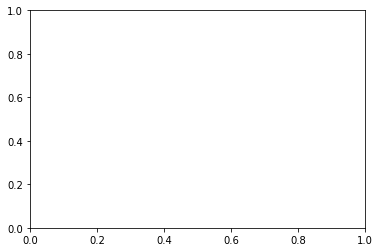

In [21]:
plt.plot(range(run),err_dis,label='Discriminator')
plt.plot(range(run),err_gen,label='Generator')
plt.legend()
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [ ]:
plt.savefig('loss_trend.jpg')

In [22]:
torch.save(netD,'Discriminator network 1')
torch.save(netG,'Generator network 1')

C:\Users\DHARMIK\Anaconda3\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\DHARMIK\Anaconda3\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [4]:
# a=torch.load('Discriminator network') #use this line to save model in variable 'a'